In [245]:
import gpxpy
import gpxpy.gpx
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from folium.vector_layers import Rectangle
from shapely.geometry import LineString
from shapely.ops import unary_union
from shapely.geometry import Point
import pandas as pd
from math import exp, sqrt, pi
import networkx as nx
from shapely.geometry import LineString, Point
from geopy.distance import geodesic, great_circle

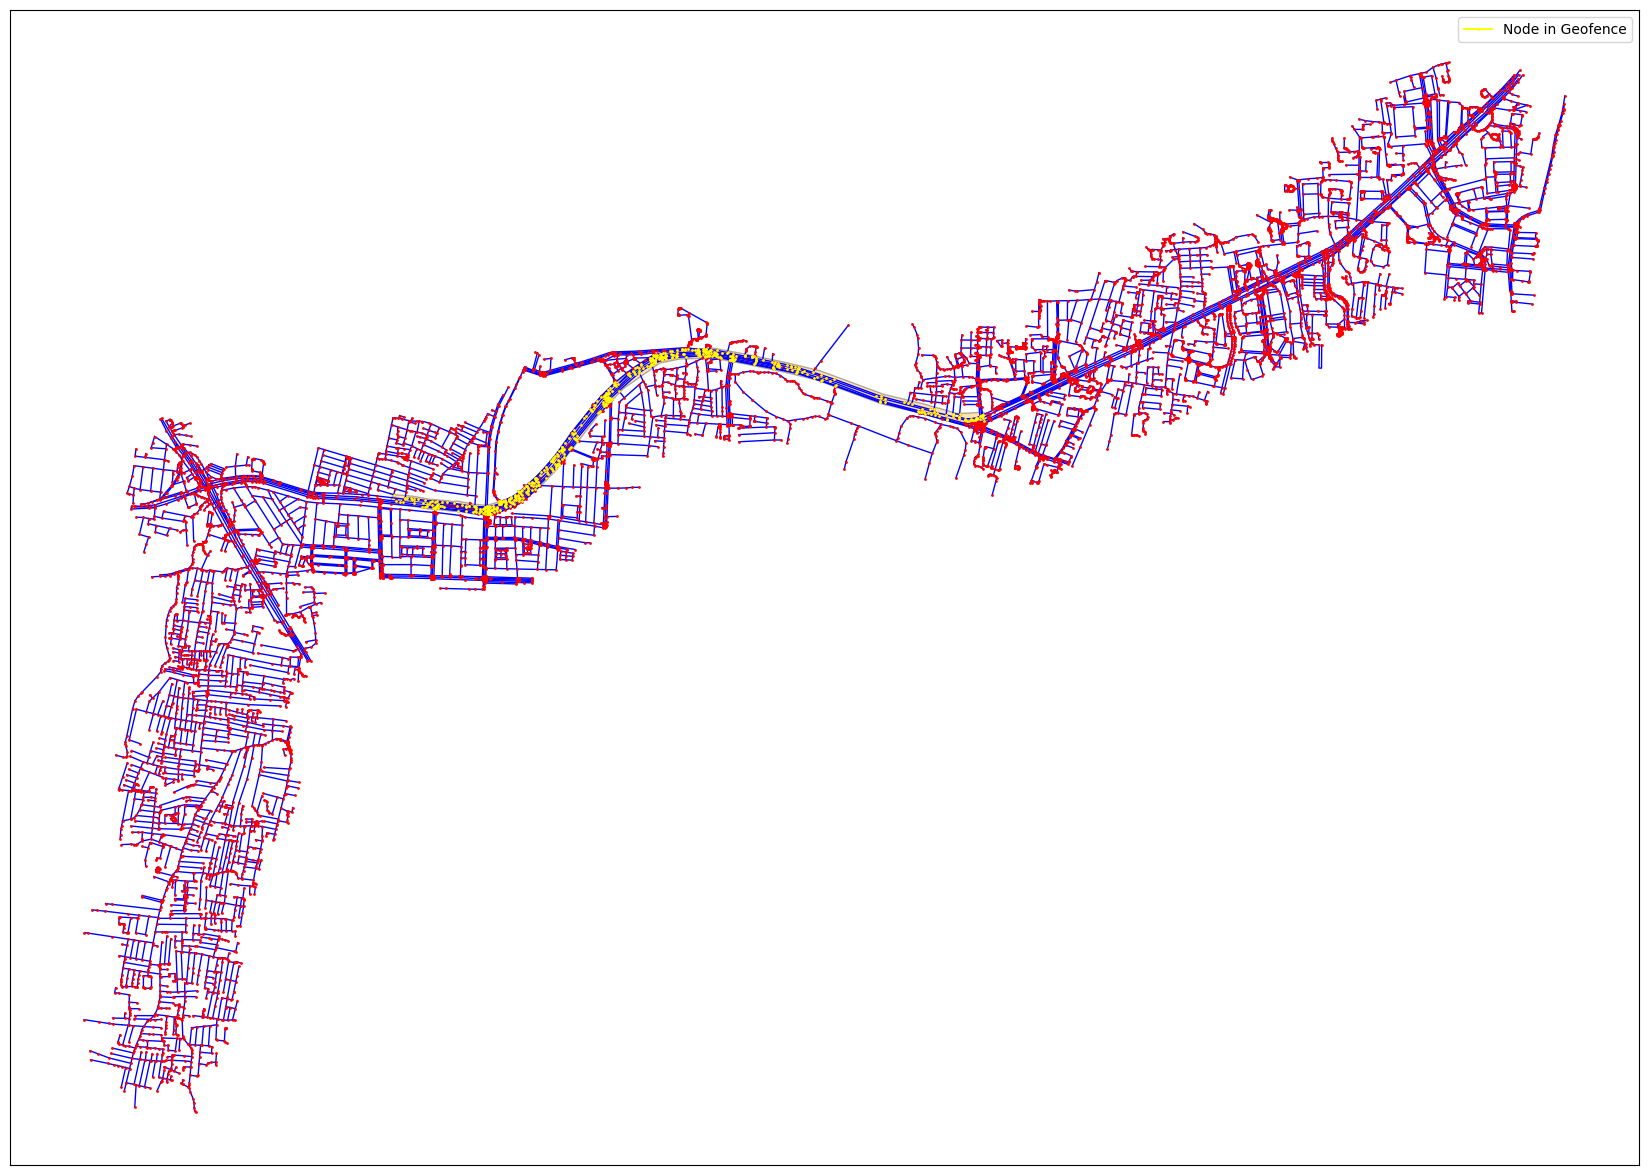

571
[(77.6629056, 12.921278), (77.662925, 12.9214166), (77.6466606, 12.9233911), (77.6616849, 12.9216797), (77.6375826, 12.9161569), (77.6375846, 12.9161891), (77.6452762, 12.9228224), (77.6441317, 12.921639), (77.6439499, 12.9214258), (77.6423677, 12.9193957), (77.6420254, 12.9189324), (77.6419042, 12.9188036), (77.6417662, 12.9186481), (77.6412176, 12.9180409), (77.6409007, 12.9177267), (77.6405881, 12.9174383), (77.6404303, 12.9172982), (77.6402943, 12.9171774), (77.6401394, 12.9170382), (77.6400368, 12.9169676), (77.6397761, 12.9167882), (77.6395847, 12.9166754), (77.6392547, 12.9165392), (77.6391419, 12.9165055), (77.6390307, 12.916469), (77.6389582, 12.9164893), (77.6655496, 12.921135), (77.6655579, 12.9210809), (77.6382615, 12.9161919), (77.6382608, 12.9161749), (77.6382588, 12.9161262), (77.649974, 12.9244696), (77.649937, 12.9245563), (77.6498925, 12.9245823), (77.6498537, 12.924589), (77.6497268, 12.924611), (77.6495523, 12.9246176), (77.6493442, 12.9246511), (77.6491711, 12.

In [246]:
fp = "/Users/ashwin/Desktop/IIIT/OSM version - within 500m of the path/For_Route_g1_i79_500m.shp"
data = gpd.read_file(fp)

G = nx.Graph()

for i, node in enumerate(G.nodes()):
    G.nodes[node]['shapefile_index'] = i

for line in data.geometry:
    if line.geom_type == 'LineString':
        start, end = Point(line.coords[0]), Point(line.coords[-1])
        length = line.length
        G.add_node(tuple(start.coords[0]), pos=tuple(start.coords[0]))
        G.add_node(tuple(end.coords[0]), pos=tuple(end.coords[0]))
        G.add_edge(tuple(start.coords[0]), tuple(end.coords[0]), geometry=line)

gpx_file_path = '/Users/ashwin/Desktop/IIIT/fefa3de2-c689-4017-a629-baf7e68f5d69_493.gpx'
with open(gpx_file_path, 'r') as gpx_file:
    gpx = gpxpy.parse(gpx_file)

start_index_2 = 149
end_index_2 = 221
observations_2 = []

for track in gpx.tracks:
    for segment in track.segments:
        for i, point in enumerate(segment.points):
            if start_index_2 <= i < end_index_2:
                observations_2.append((point.longitude, point.latitude))

observations_2_no_duplicates = []
for i, point in enumerate(observations_2):
    if i == 0 or point != observations_2[i - 1]:
        observations_2_no_duplicates.append(point)

gpx_path = LineString(observations_2_no_duplicates)
gpx_gdf = gpd.GeoDataFrame(geometry=[gpx_path], crs="EPSG:4326")
gpx_gdf = gpx_gdf.to_crs(epsg=3857)

geofence = gpx_gdf.buffer(30)
geofence = geofence.to_crs(epsg=4326)

connected_components = sorted(nx.connected_components(G), key=len, reverse=True)

if len(connected_components) > 0:
    subgraph_2 = G.subgraph(connected_components[0]).copy()
    pos_2 = nx.get_node_attributes(subgraph_2, 'pos')

    states_in_geofence_2 = []
    for node, position in pos_2.items():
        point = Point(position)
        if geofence.geometry[0].contains(point):
            states_in_geofence_2.append(position)

    fig, ax = plt.subplots(figsize=(30, 15))

    for edge in subgraph_2.edges(data=True):
        line = edge[2]['geometry']
        x, y = line.xy
        ax.plot(x, y, color='blue', linewidth=1)

    nx.draw_networkx_nodes(subgraph_2, pos_2, ax=ax, node_size=1, node_color='red')

    for point in observations_2_no_duplicates:
        ax.plot(point[0], point[1], marker='o', color='purple', markersize=1)

    geofence.plot(ax=ax, color='orange', alpha=0.3, edgecolor='black')

    for node in states_in_geofence_2:
        ax.plot(node[0], node[1], marker='o', color='yellow', markersize=1, label="Node in Geofence")

    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[:1], labels[:1])

    plt.show()
    print(len(states_in_geofence_2))
    print(states_in_geofence_2)

def calculate_geodesic_distance(points):
    total_distance = 0.0
    for i in range(1, len(points)):
        total_distance += geodesic(points[i-1], points[i]).kilometers
    return total_distance

total_geodesic_distance_km_2 = calculate_geodesic_distance(observations_2_no_duplicates)
print(f"Total geodesic distance of observation path: {total_geodesic_distance_km_2:.2f} km")

print(len(observations_2_no_duplicates))
print(observations_2_no_duplicates)

In [247]:
observations_2_no_duplicates = []
for i, point in enumerate(observations_2):
    if i == 0 or point != observations_2[i - 1]:
        observations_2_no_duplicates.append(point)

def find_closest_nodes_with_distances(graph, observations):
    node_positions = nx.get_node_attributes(graph, 'pos')
    closest_nodes = []
    distances = []
    for obs in observations:
        closest_node = min(
            node_positions.keys(),
            key=lambda node: geodesic(obs, node_positions[node]).meters,
        )
        closest_distance = geodesic(obs, node_positions[closest_node]).meters
        closest_nodes.append(closest_node)
        distances.append(closest_distance)
    return closest_nodes, distances
closest_nodes_to_observations, distances_to_closest_nodes = find_closest_nodes_with_distances(G, observations_2_no_duplicates)
print("Closest nodes to observations:", closest_nodes_to_observations)
print("Distances to closest nodes (meters):", distances_to_closest_nodes)

Closest nodes to observations: [(77.6332191, 12.9164826), (77.6336386, 12.9164461), (77.6336386, 12.9164461), (77.6341239, 12.9165399), (77.6350673, 12.9163386), (77.6352136, 12.9162922), (77.6358664, 12.9161841), (77.636059, 12.9164109), (77.636059, 12.9164109), (77.6364267, 12.916358), (77.6364267, 12.916358), (77.6364267, 12.916358), (77.6364267, 12.916358), (77.6364267, 12.916358), (77.6365988, 12.9162034), (77.6365988, 12.9162034), (77.6366438, 12.91596), (77.6368608, 12.9162946), (77.6368608, 12.9162946), (77.637279, 12.9162052), (77.6372829, 12.91623), (77.6372829, 12.91623), (77.6374739, 12.9159018), (77.6380362, 12.9160363), (77.6382582, 12.9159679), (77.6384592, 12.916007), (77.6389516, 12.9162976), (77.639445, 12.9165908), (77.6394904, 12.9165345), (77.6398678, 12.9165379), (77.6400242, 12.9165847), (77.6400242, 12.9165847), (77.6401377, 12.9168879), (77.640176, 12.9168025), (77.6402516, 12.916636), (77.6407077, 12.9173647), (77.64108, 12.9175322), (77.6411561, 12.917904), (

In [248]:
def swap_coordinates(array):
    return [(lat, lon) for lon, lat in array]
observations_2_swapped = swap_coordinates(observations_2_no_duplicates)
states_in_geofence_2_swapped = swap_coordinates(states_in_geofence_2)
closest_nodes_to_observations_swapped = swap_coordinates(closest_nodes_to_observations)
print("observations_1_swapped:", observations_2_swapped) 
print("states_in_geofence_1_swapped:", states_in_geofence_2_swapped)
print("closest_nodes_to_observations swapped:", closest_nodes_to_observations_swapped)

observations_1_swapped: [(12.9165871, 77.6332063), (12.9165517, 77.6336246), (12.9165523, 77.6336503), (12.9165062, 77.6341376), (12.9163405, 77.6350269), (12.9163332, 77.6352159), (12.91627, 77.635962), (12.9162616, 77.636079), (12.9162442, 77.6361418), (12.9162279, 77.6362461), (12.9162267, 77.63625), (12.9162186, 77.6364129), (12.9162233, 77.6364242), (12.9162417, 77.6364883), (12.9162433, 77.6366067), (12.9162297, 77.6366534), (12.9162133, 77.6366883), (12.9161937, 77.63685), (12.9161874, 77.6368896), (12.9161245, 77.6372109), (12.9161018, 77.6373415), (12.9161017, 77.6373417), (12.9160789, 77.6374748), (12.9160303, 77.6380449), (12.9160396, 77.6382722), (12.9160673, 77.638435), (12.9162076, 77.6389443), (12.9163745, 77.6394206), (12.916404, 77.6394914), (12.9165862, 77.6398508), (12.9167067, 77.6400366), (12.9167067, 77.6400367), (12.916785, 77.64012), (12.9168501, 77.640215), (12.9168716, 77.6402441), (12.9172638, 77.640687), (12.917624, 77.641124), (12.9177027, 77.6412011), (12.

In [249]:
score = None
pred = None
shapefile_indices = None
IT = None

def create_graph_from_shapefile(filepath):
    data = gpd.read_file(filepath)
    G = nx.Graph()
    for idx, line in enumerate(data.geometry):
        if line.geom_type == 'LineString':
            start, end = Point(line.coords[0]), Point(line.coords[-1])
            geodesic_distance = geodesic(start.coords[0], end.coords[0]).meters
            G.add_node(tuple(start.coords[0]), pos=tuple(start.coords[0]), shapefile_index=idx)
            G.add_node(tuple(end.coords[0]), pos=tuple(end.coords[0]), shapefile_index=idx)
            G.add_edge(
                tuple(start.coords[0]),
                tuple(end.coords[0]),
                geometry=line,
                weight=geodesic_distance,
            )
    return G

def calculate_graph_distances(graph, states):
    n_states = len(states)
    distances = np.zeros((n_states, n_states))
    for i in range(n_states):
        for j in range(n_states):
            if i != j:
                try:
                    path_length = nx.shortest_path_length(
                        graph,
                        source=tuple(states[i]),
                        target=tuple(states[j]),
                        weight="weight",
                    )
                    distances[i, j] = path_length
                except nx.NetworkXNoPath:
                    distances[i, j] = np.inf
    return distances

def calculate_beta_values(observations, closest_nodes_to_observations, state_distances_2):
    n_obs = len(observations)
    beta_values = []
    node_to_index = {node: idx for idx, node in enumerate(closest_nodes_to_observations)}
    for k in range(n_obs - 1): 
        node_1 = closest_nodes_to_observations[k]
        node_2 = closest_nodes_to_observations[k + 1]
        idx_1 = node_to_index[node_1]
        idx_2 = node_to_index[node_2]
        great_circle_distance = geodesic(observations[k], observations[k + 1]).meters
        route_distance = state_distances_2[idx_1, idx_2]
        diff_distance = abs(great_circle_distance - route_distance)
        beta_values.append(diff_distance)
    mediant_value = np.median(beta_values)
    beta = mediant_value / np.log(2)
    print(f"Beta value: {beta}")
    return beta

def calculate_transition_matrix(states, zVec, observations, state_distances):
    n_states = len(states)
    n_obs = len(zVec)
    TRANS = np.zeros((n_states, n_states, n_obs))
    beta = calculate_beta_values(observations, closest_nodes_to_observations, state_distances)
    for k in range(n_obs):
        for i in range(n_states):
            for j in range(n_states):
                dij = abs(state_distances[i, j] - zVec[k])
                TRANS[i, j, k] = (1 / beta) * np.exp(-dij / beta)
        
        row_sums = np.sum(TRANS[:, :, k], axis=1)
        TRANS[:, :, k] = np.divide(TRANS[:, :, k], row_sums[:, None], where=row_sums[:, None] != 0)
    return TRANS

def calculate_emission_matrix(states, observations):
    n_states = len(states)
    n_obs = len(observations)
    distances = np.zeros((n_states, n_obs))
    for i in range(n_states):
        for j in range(n_obs):
            distances[i, j] = great_circle(states[i], observations[j]).m
    sigz = 1.4826 * np.median(distances_to_closest_nodes)
    print(sigz)
    EMIS = (1 / (np.sqrt(2 * np.pi) * sigz)) * np.exp(-0.5 * (distances / sigz) ** 2)
    return EMIS

def viterbi_algorithm(states, observations, zVec, PRIOR, state_distances):
    global score, pred, IT
    n_states = len(states)
    T = len(observations)
    TRANS = calculate_transition_matrix(states, zVec, observations, state_distances)
    EMIS = calculate_emission_matrix(states, observations)
    score = np.zeros((n_states, T))
    pred = np.zeros((n_states, T), dtype=int)
    score[:, 0] = PRIOR * EMIS[:, 0]
    for t in range(1, T):
        temp_score = score[:, t - 1][:, None] * TRANS[:, :, t - 1]
        pred[:, t] = np.argmax(temp_score, axis=0)
        score[:, t] = np.max(temp_score, axis=0) * EMIS[:, t]
    IT = np.zeros(T, dtype=int)
    IT[-1] = np.argmax(score[:, -1])
    for t in range(T - 1, 0, -1):
        IT[t - 1] = pred[IT[t], t]
    return IT

def calculate_geodesic_distance(points):
    total_distance = 0.0
    for i in range(1, len(points)):
        total_distance += geodesic(points[i-1], points[i]).meters
    return total_distance

fp = "/Users/ashwin/Desktop/IIIT/OSM version - within 500m of the path/For_Route_g1_i79_500m.shp"
data = gpd.read_file(fp)
G = create_graph_from_shapefile(fp)
gpx_file_path = '/Users/ashwin/Desktop/IIIT/fefa3de2-c689-4017-a629-baf7e68f5d69_493.gpx'
with open(gpx_file_path, 'r') as gpx_file:
    gpx = gpxpy.parse(gpx_file)
obs_2 = np.array(observations_2_no_duplicates)
s = np.array(states_in_geofence_2)
s_2 = np.array(closest_nodes_to_observations)
zVec_2 = [geodesic(obs_2[i], obs_2[i + 1]).meters for i in range(len(obs_2) - 1)]
state_distances = calculate_graph_distances(G, s)
state_distances_2 = calculate_graph_distances(G, s_2)
PRIOR_2 = np.ones(len(states_in_geofence_2)) / len(states_in_geofence_2)
matched_states_2 = viterbi_algorithm(states_in_geofence_2, obs_2, zVec_2, PRIOR_2, state_distances)
total_geodesic_distance_km_2 = calculate_geodesic_distance(observations_2_no_duplicates)
print(matched_states_2)
matched_coords = [states_in_geofence_2[i] for i in matched_states_2]
matched_shapefile_indices = [G.nodes[tuple(coord)]['shapefile_index'] for coord in matched_coords]
print("Matched shapefile indices:", matched_shapefile_indices)

Beta value: 47.760035489548756
7.976485300520149
[195 197 197 198 200 546 543 543 543 542 542 542 542 542 542 541 541 541
 541 512 513 513 540 526 307 516 245 281 281 279 278 278 278 277 277 275
 272 272 270 269 266 263 263 262 262 262 262 116 130 471 483 564 440 533
 295 297 159 147 412]
Matched shapefile indices: [3607, 3609, 3609, 3610, 4752, 11223, 11220, 11220, 11220, 11219, 11219, 11219, 11219, 11219, 11219, 11218, 11218, 11218, 11218, 10931, 11217, 11217, 11216, 10933, 4469, 10559, 10560, 4298, 4298, 4296, 4295, 4295, 4295, 4294, 4294, 4292, 4289, 4289, 4287, 4286, 4283, 4280, 4280, 4279, 4279, 4279, 4279, 1947, 1961, 9700, 9713, 11780, 7914, 11006, 4355, 4357, 3512, 11424, 7721]
7.976485300520149
[195 197 197 198 200 546 543 543 543 542 542 542 542 542 542 541 541 541
 541 512 513 513 540 526 307 516 245 281 281 279 278 278 278 277 277 275
 272 272 270 269 266 263 263 262 262 262 262 116 130 471 483 564 440 533
 295 297 159 147 412]
Matched shapefile indices: [3607, 3609, 3609,

In [250]:
matched_coordinates_2 = [states_in_geofence_2[state_idx] for state_idx in matched_states_2]

unique_matched_coordinates_2 = [
    coord for i, coord in enumerate(matched_coordinates_2)
    if i == 0 or coord != matched_coordinates_2[i - 1]
]

print(f"Number of unique matched coordinates: {len(unique_matched_coordinates_2)}")
for coord in unique_matched_coordinates_2:
    lon, lat = coord
    print(f"Latitude: {lat}, Longitude: {lon}")

print("\nAll matched coordinates:")
for coord in matched_coordinates_2:
    lon, lat = coord
    print(f"Latitude: {lat}, Longitude: {lon}")


Number of unique matched coordinates: 38
Latitude: 12.9164826, Longitude: 77.6332191
Latitude: 12.9164461, Longitude: 77.6336386
Latitude: 12.9163977, Longitude: 77.6342411
Latitude: 12.9163386, Longitude: 77.6350673
Latitude: 12.9164862, Longitude: 77.6352444
Latitude: 12.9164109, Longitude: 77.636059
Latitude: 12.916358, Longitude: 77.6364267
Latitude: 12.9162946, Longitude: 77.6368608
Latitude: 12.9162052, Longitude: 77.637279
Latitude: 12.91623, Longitude: 77.6372829
Latitude: 12.916192, Longitude: 77.6375599
Latitude: 12.9161178, Longitude: 77.6380625
Latitude: 12.9159679, Longitude: 77.6382582
Latitude: 12.9161802, Longitude: 77.6384108
Latitude: 12.9163251, Longitude: 77.6389427
Latitude: 12.9165908, Longitude: 77.639445
Latitude: 12.9167503, Longitude: 77.6397811
Latitude: 12.9169593, Longitude: 77.6400625
Latitude: 12.9170544, Longitude: 77.6401918
Latitude: 12.9174889, Longitude: 77.6407377
Latitude: 12.917904, Longitude: 77.6411561
Latitude: 12.9183021, Longitude: 77.6415146


--- Path Segment Distances (Shortest Path Between Consecutive Matched States) ---
Segment from state 3607 to 3609: 46.84 meters
Segment from state 3609 to 3609: 0.00 meters
Segment from state 3609 to 3610: 67.27 meters
Segment from state 3610 to 4752: 92.25 meters
Segment from state 4752 to 11223: 325.19 meters
Segment from state 11223 to 11220: 90.96 meters
Segment from state 11220 to 11220: 0.00 meters
Segment from state 11220 to 11220: 0.00 meters
Segment from state 11220 to 11219: 41.07 meters
Segment from state 11219 to 11219: 0.00 meters
Segment from state 11219 to 11219: 0.00 meters
Segment from state 11219 to 11219: 0.00 meters
Segment from state 11219 to 11219: 0.00 meters
Segment from state 11219 to 11219: 0.00 meters
Segment from state 11219 to 11218: 48.49 meters
Segment from state 11218 to 11218: 0.00 meters
Segment from state 11218 to 11218: 0.00 meters
Segment from state 11218 to 11218: 0.00 meters
Segment from state 11218 to 10931: 47.89 meters
Segment from state 10931

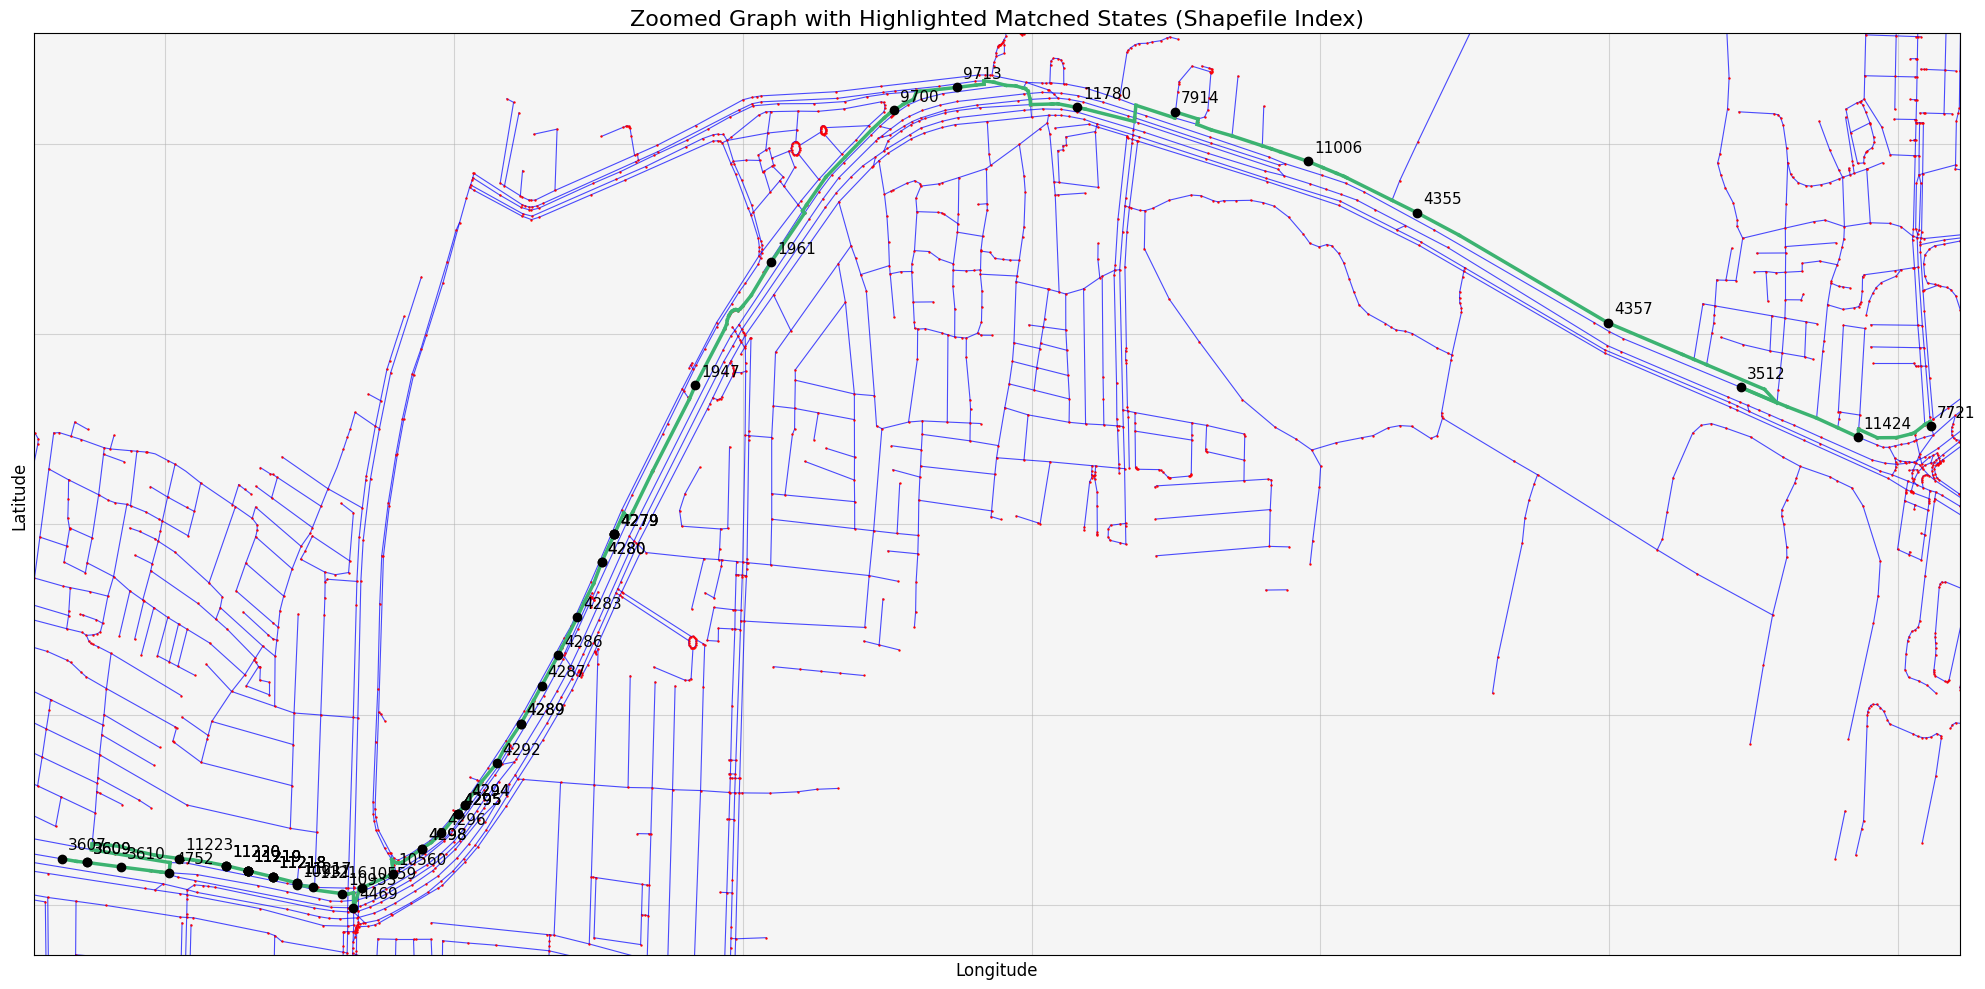

In [251]:
import geopandas as gpd
import networkx as nx
import matplotlib.pyplot as plt
from shapely.geometry import Point, LineString
from geopy.distance import geodesic

fp = "/Users/ashwin/Desktop/IIIT/OSM version - within 500m of the path/For_Route_g1_i79_500m.shp"
data = gpd.read_file(fp)

G = nx.Graph()
coord_to_index = {}

for idx, line in enumerate(data.geometry):
    if line.geom_type == 'LineString':
        start, end = Point(line.coords[0]), Point(line.coords[-1])
        start_coord = tuple(start.coords[0])
        end_coord = tuple(end.coords[-1])
        G.add_node(start_coord, pos=start_coord)
        G.add_node(end_coord, pos=end_coord)
        G.add_edge(start_coord, end_coord, geometry=line)
        coord_to_index[start_coord] = idx
        coord_to_index[end_coord] = idx

pos = nx.get_node_attributes(G, 'pos')

valid_highlighted_nodes_2 = [tuple(coord) for coord in matched_coordinates_2 if tuple(coord) in pos]
valid_highlighted_nodes_2 = [node for node in valid_highlighted_nodes_2 if node in pos]

def geodesic_distance(a, b):
    return geodesic(a, b).meters

def find_shortest_path_between_nodes(G, start_node, end_node):
    return nx.shortest_path(G, source=start_node, target=end_node, weight=lambda u, v, d: geodesic_distance(pos[u], pos[v]))

def create_path_from_highlighted_nodes(G, nodes):
    path = [nodes[0]]
    visited = set(path)
    for i in range(len(nodes) - 1):
        segment = find_shortest_path_between_nodes(G, nodes[i], nodes[i + 1])
        for node in segment[1:]:
            if node not in visited:
                path.append(node)
                visited.add(node)
    return path

def calculate_path_segment_distances(G, nodes):
    segment_distances = []
    total_path_length = 0
    print("\n--- Path Segment Distances (Shortest Path Between Consecutive Matched States) ---")
    for i in range(len(nodes) - 1):
        segment = find_shortest_path_between_nodes(G, nodes[i], nodes[i + 1])
        distance = 0
        for j in range(len(segment) - 1):
            pt1 = segment[j]
            pt2 = segment[j + 1]
            distance += geodesic(pos[pt1], pos[pt2]).meters
        segment_distances.append(distance)
        total_path_length += distance
        print(f"Segment from state {coord_to_index[nodes[i]]} to {coord_to_index[nodes[i+1]]}: {distance:.2f} meters")
    print(f"\nTotal path length over shortest paths: {total_path_length:.2f} meters")
    return segment_distances, total_path_length

if len(valid_highlighted_nodes_2) > 2:
    path_nodes_2 = create_path_from_highlighted_nodes(G, valid_highlighted_nodes_2)
else:
    path_nodes_2 = valid_highlighted_nodes_2

segment_distances, total_path_length = calculate_path_segment_distances(G, valid_highlighted_nodes_2)

fig, ax = plt.subplots(figsize=(20, 10))

for edge in G.edges(data=True):
    line = edge[2]['geometry']
    x, y = line.xy
    ax.plot(x, y, color='blue', linewidth=0.8, alpha=0.7)

nx.draw_networkx_nodes(G, pos, ax=ax, node_size=0.5, node_color='red')

for node in valid_highlighted_nodes_2:
    x, y = node
    ax.plot(x, y, marker='o', color='black', markersize=6, zorder=3)
    idx_label = coord_to_index.get(node, 'N/A')
    ax.text(x + 0.0001, y + 0.0001, str(idx_label), fontsize=11, color='black', zorder=4)

for i in range(len(path_nodes_2) - 1):
    start = path_nodes_2[i]
    end = path_nodes_2[i + 1]
    line = LineString([Point(start), Point(end)])
    x, y = line.xy
    ax.plot(x, y, color='mediumseagreen', linewidth=2.5, linestyle='-', zorder=2)
x_coords = [coord[0] for coord in path_nodes_2]
y_coords = [coord[1] for coord in path_nodes_2]
margin = 0.0005
ax.set_xlim(min(x_coords) - margin, max(x_coords) + margin)
ax.set_ylim(min(y_coords) - margin, max(y_coords) + margin)
ax.set_facecolor('whitesmoke')
ax.tick_params(axis='both', which='major', labelsize=10)
plt.title("Zoomed Graph with Highlighted Matched States (Shapefile Index)", fontsize=16)
plt.xlabel("Longitude", fontsize=12)
plt.ylabel("Latitude", fontsize=12)
plt.grid(True, linestyle='-', alpha=0.5)
plt.tight_layout()
plt.show()


+---------------+-------------+-----------------+
|   Path Length |    Geodesic |   distance_diff |
+===============+=============+=================+
|       46.8425 |  45.5629    |       1.27957   |
+---------------+-------------+-----------------+
|        0      |   2.78978   |       2.78978   |
+---------------+-------------+-----------------+
|       67.2744 |  53.1276    |      14.1468    |
+---------------+-------------+-----------------+
|       92.25   |  98.2332    |       5.98325   |
+---------------+-------------+-----------------+
|      325.189  |  20.5264    |     304.662     |
+---------------+-------------+-----------------+
|       90.9627 |  81.2688    |       9.69388   |
+---------------+-------------+-----------------+
|        0      |  12.7309    |      12.7309    |
+---------------+-------------+-----------------+
|        0      |   7.08176   |       7.08176   |
+---------------+-------------+-----------------+
|       41.0703 |  11.4615    |      29.6088    |


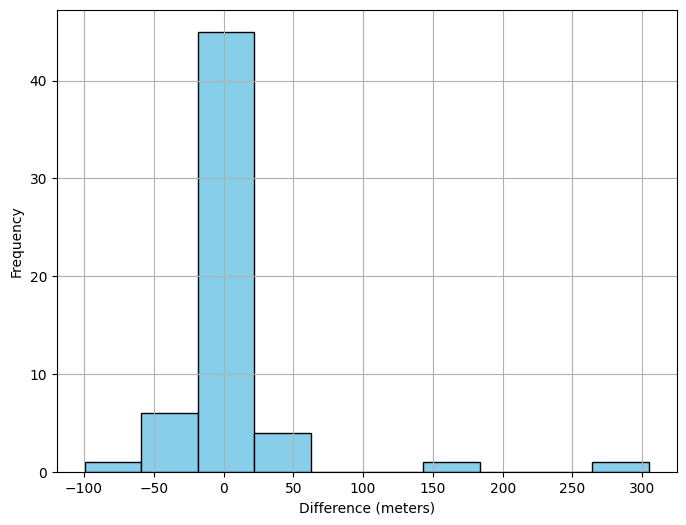

In [252]:
from geopy.distance import geodesic
import numpy as np
import matplotlib.pyplot as plt
from tabulate import tabulate

distances_2_2 = []
distances_2 = []
highlighted_distances = []
total_distance = 0

def calculate_consecutive_geodesic_distances(points, distances_list):
    total = 0
    for i in range(1, len(points)):
        distance = geodesic(points[i-1], points[i]).meters
        total += distance
        distances_list.append(distance)
    return distances_list, total

consecutive_distances_km_2, total_distance = calculate_consecutive_geodesic_distances(path_nodes_2, distances_2)

valid_highlighted_indices = [path_nodes_2.index(node) for node in valid_highlighted_nodes_2 if node in path_nodes_2]

for i in range(1, len(valid_highlighted_indices)):
    start_index, end_index = valid_highlighted_indices[i-1], valid_highlighted_indices[i]
    highlighted_distance = np.sum(distances_2[start_index:end_index])
    highlighted_distances.append(highlighted_distance)

gpx_coordinates_obs = [(lat, lon) for lon, lat in observations_2_no_duplicates]
consecutive_distances_km_2, _ = calculate_consecutive_geodesic_distances(gpx_coordinates_obs, distances_2_2)

data = []
for i in range(max(len(highlighted_distances), len(distances_2_2))):
    row = [
        highlighted_distances[i] if i < len(highlighted_distances) else "", 
        distances_2_2[i] if i < len(distances_2_2) else "", 
        abs(highlighted_distances[i] - distances_2_2[i]) if i < len(highlighted_distances) and i < len(distances_2_2) else ""
    ]
    data.append(row)

headers = ["Path Length", "Geodesic", "distance_diff"]
print(tabulate(data, headers=headers, tablefmt="grid"))

if len(highlighted_distances) == len(distances_2_2):
    plt.figure(figsize=(8, 6))
    plt.hist(np.array(highlighted_distances) - np.array(distances_2_2), bins=10, edgecolor='black', color='skyblue')
    plt.xlabel("Difference (meters)")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()
else:
    print("\nThe highlighted_distances and distances_2_2 arrays have different lengths. Cannot compute differences.")


In [253]:
from tabulate import tabulate
data = []
max_len = min(len(highlighted_distances), len(distances_2_2))
for i in range(max_len):
    path_length = highlighted_distances[i]
    geodesic = distances_2_2[i]
    distance_diff = abs(path_length - geodesic)

    if distance_diff > 100:
        data.append([i, path_length, geodesic, distance_diff])

print(tabulate(data, headers=["Index", "Path Length (m)", "Geodesic (m)", "Distance Diff (m)"], tablefmt="grid"))

significant_indices = [row[0] for row in data]
print("\nIndices with distance_diff > 100:")
print(significant_indices)


+---------+-------------------+----------------+---------------------+
|   Index |   Path Length (m) |   Geodesic (m) |   Distance Diff (m) |
+=========+===================+================+=====================+
|       4 |           325.189 |        20.5264 |             304.662 |
+---------+-------------------+----------------+---------------------+
|      55 |           398.042 |       244.524  |             153.518 |
+---------+-------------------+----------------+---------------------+

Indices with distance_diff > 100:
[4, 55]


Total distance of the shortest path: 4118.63 meters
Total geodesic distance : 3634.80 meters

Observation to Matched Node Mapping (within Geofence):
  Obs Index  Obs Coord (lon, lat)      Matched Node Coord          Shapefile Index
-----------  ------------------------  ------------------------  -----------------
          0  (77.6332063, 12.9165871)  (77.6332191, 12.9164826)               3607
          1  (77.6336246, 12.9165517)  (77.6336386, 12.9164461)               3609
          2  (77.6336503, 12.9165523)  (77.6336386, 12.9164461)               3609
          3  (77.6341376, 12.9165062)  (77.6342411, 12.9163977)               3610
          4  (77.6350269, 12.9163405)  (77.6350673, 12.9163386)               4752
          5  (77.6352159, 12.9163332)  (77.6352444, 12.9164862)              11223
          6  (77.635962, 12.91627)     (77.636059, 12.9164109)               11220
          7  (77.636079, 12.9162616)   (77.636059, 12.9164109)               11220
          8  (77.6361

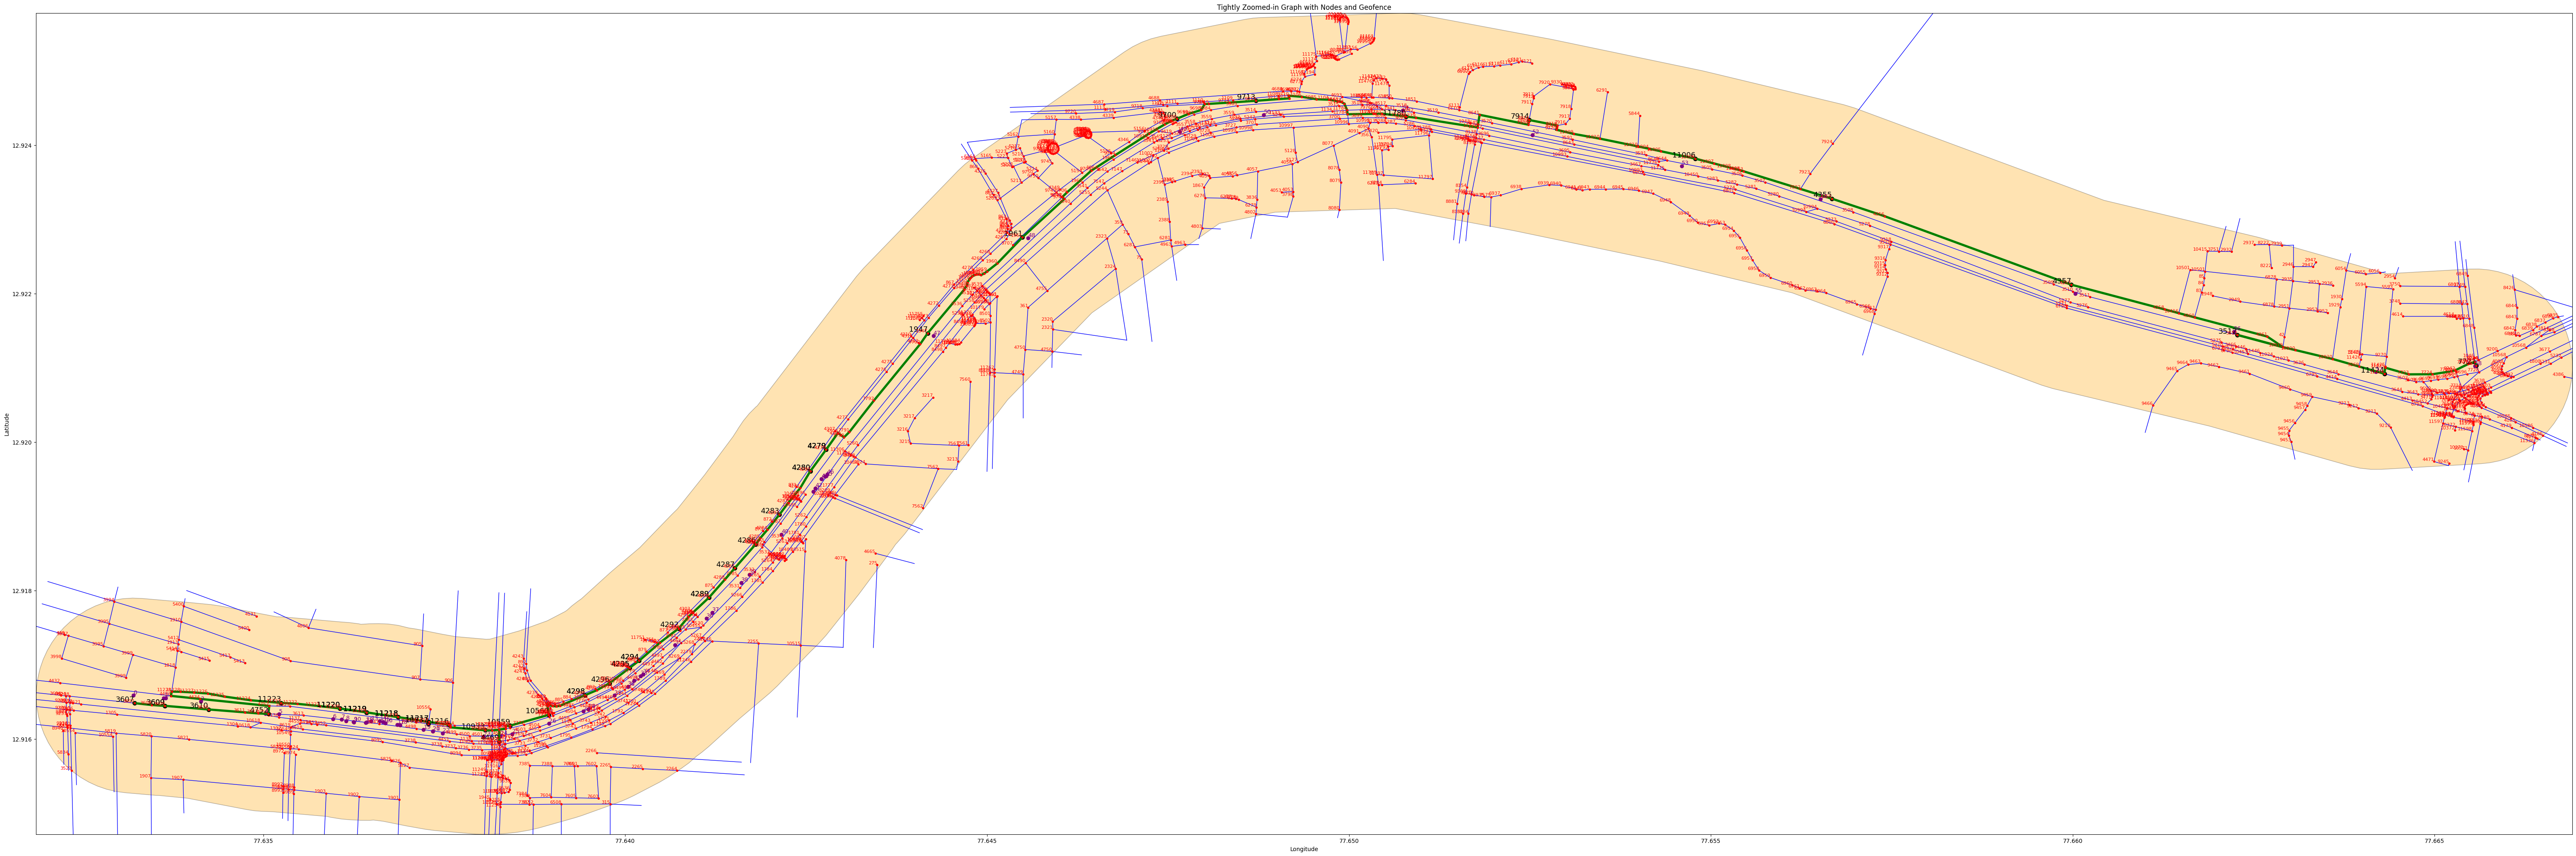

In [254]:
import networkx as nx
import matplotlib.pyplot as plt
import gpxpy
import geopandas as gpd
from shapely.geometry import LineString, Point
from geopy.distance import geodesic
from tabulate import tabulate

fp = "/Users/ashwin/Desktop/IIIT/OSM version - within 500m of the path/For_Route_g1_i79_500m.shp"
gpx_file_path = '/Users/ashwin/Desktop/IIIT/fefa3de2-c689-4017-a629-baf7e68f5d69_493.gpx'

data = gpd.read_file(fp)
G = nx.Graph()
coord_to_index = {}

for idx, line in enumerate(data.geometry):
    if line.geom_type == 'LineString':
        start, end = Point(line.coords[0]), Point(line.coords[-1])
        start_coord = tuple(start.coords[0])
        end_coord = tuple(end.coords[-1])
        G.add_node(start_coord, pos=start_coord)
        G.add_node(end_coord, pos=end_coord)
        G.add_edge(start_coord, end_coord, geometry=line)
        coord_to_index[start_coord] = idx
        coord_to_index[end_coord] = idx

with open(gpx_file_path, 'r') as gpx_file:
    gpx = gpxpy.parse(gpx_file)

start_index_2 = 149
end_index_2 = 221

observations_2 = [
    (point.longitude, point.latitude)
    for track in gpx.tracks
    for segment in track.segments
    for i, point in enumerate(segment.points)
    if start_index_2 <= i < end_index_2
]

observations_2_no_duplicates = [pt for i, pt in enumerate(observations_2) if i == 0 or pt != observations_2[i - 1]]

gpx_path = LineString(observations_2_no_duplicates)
gpx_gdf = gpd.GeoDataFrame(geometry=[gpx_path], crs="EPSG:4326").to_crs(epsg=3857)
geofence = gpx_gdf.buffer(150).to_crs(epsg=4326)

connected_components = sorted(nx.connected_components(G), key=len, reverse=True)

if connected_components:
    subgraph_2 = G.subgraph(connected_components[0]).copy()
    pos_2 = nx.get_node_attributes(subgraph_2, 'pos')

    nodes_in_geofence = [node for node, position in pos_2.items() if geofence.geometry[0].contains(Point(position))]
    edges_in_geofence = [edge for edge in subgraph_2.edges(data=True) if geofence.geometry[0].intersects(edge[2]['geometry'])]

    def geodesic_distance(a, b):
        return geodesic(a, b).kilometers

    def shortest_path_geodesic_weight(G, source, target):
        return nx.shortest_path(G, source=source, target=target, weight=lambda u, v, d: geodesic_distance(pos_2[u], pos_2[v]))

    fig, ax = plt.subplots(figsize=(80, 80))

    for edge in edges_in_geofence:
        line = edge[2]['geometry']
        x, y = line.xy
        ax.plot(x, y, color='blue', linewidth=1)

    valid_highlighted_nodes_2 = [tuple(coord) for coord in matched_coordinates_2 if tuple(coord) in pos_2]
    valid_nodes_in_geofence = [node for node in valid_highlighted_nodes_2 if Point(pos_2[node]).within(geofence.geometry[0])]

    for idx, node in enumerate(valid_nodes_in_geofence):
        x, y = node
        ax.plot(x, y, marker='o', color='black', markersize=7)
        node_index = coord_to_index.get((x, y), None)
        ax.text(x, y, str(node_index), fontsize=13, color='black', ha='right', va='bottom')

    for i, pt in enumerate(observations_2_no_duplicates):
        obs_point = Point(pt)
        if geofence.geometry[0].contains(obs_point):
            ax.plot(pt[0], pt[1], marker='o', color='purple', markersize=6)
            ax.text(pt[0], pt[1], str(i), fontsize=10, color='purple', ha='left', va='bottom')

    geofence.plot(ax=ax, color='orange', alpha=0.3, edgecolor='black')

    plotted_edges = set()
    total_shortest_path_distance = 0.0
    for i in range(len(valid_nodes_in_geofence) - 1):
        start = valid_nodes_in_geofence[i]
        end = valid_nodes_in_geofence[i + 1]
        if nx.has_path(subgraph_2, start, end):
            path = shortest_path_geodesic_weight(subgraph_2, start, end)
            segment_distance = 0.0
            for j in range(len(path) - 1):
                node_start = path[j]
                node_end = path[j + 1]
                dist = geodesic_distance(pos_2[node_start], pos_2[node_end])
                segment_distance += dist
                if (node_start, node_end) not in plotted_edges:
                    line = subgraph_2[node_start][node_end]['geometry']
                    if geofence.geometry[0].intersects(line):
                        intersected_line = line.intersection(geofence.geometry[0])
                        if isinstance(intersected_line, LineString):
                            x, y = intersected_line.xy
                            ax.plot(x, y, color='green', linewidth=4, linestyle='-')
                            plotted_edges.add((node_start, node_end))
            total_shortest_path_distance += segment_distance

    def calculate_geodesic_distance(points):
        total_distance = 0.0
        for i in range(1, len(points)):
            total_distance += geodesic(points[i - 1], points[i]).kilometers
        return total_distance

    total_observation_path_distance = calculate_geodesic_distance(observations_2_no_duplicates)
    print(f"Total distance of the shortest path: {total_shortest_path_distance * 1000:.2f} meters")
    print(f"Total geodesic distance : {total_observation_path_distance * 1000:.2f} meters")

    for node in nodes_in_geofence:
        x, y = pos_2[node]
        ax.plot(x, y, marker='o', color='red', markersize=3)
        node_index = coord_to_index.get((x, y), None)
        ax.text(x, y, str(node_index), fontsize=8, color='red', ha='right', va='bottom')

    mapping_table = []
    obs_counter = 0
    for i, pt in enumerate(observations_2_no_duplicates):
        obs_point = Point(pt)
        if geofence.geometry[0].contains(obs_point):
            if obs_counter < len(valid_nodes_in_geofence):
                matched_node = valid_nodes_in_geofence[obs_counter]
                matched_index = coord_to_index.get(matched_node, "N/A")
                mapping_table.append([i, pt, matched_node, matched_index])
                obs_counter += 1

    print("\nObservation to Matched Node Mapping (within Geofence):")
    print(tabulate(mapping_table, headers=["Obs Index", "Obs Coord (lon, lat)", "Matched Node Coord", "Shapefile Index"]))

    zoom_factor = 0.000001
    minx, miny, maxx, maxy = geofence.total_bounds
    ax.set_xlim(minx - zoom_factor, maxx + zoom_factor)
    ax.set_ylim(miny - zoom_factor, maxy + zoom_factor)
    plt.title("Tightly Zoomed-in Graph with Nodes and Geofence")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.show()


Candidate idx: 3613, Angle Difference: 0.24°, Distance Difference: 0.0333 km

Top 5 candidate node numbers for observation 5: [3613]
Reassigned: original 11223 → new index: 3613, angle: 0.24°, dist: 33.33 m
Candidate idx: 3547, Angle Difference: 1.45°, Distance Difference: 0.0333 km

Top 5 candidate node numbers for observation 6: [3547]
Reassigned: original 11220 → new index: 3547, angle: 1.45°, dist: 33.28 m
Candidate idx: 3547, Angle Difference: 1.45°, Distance Difference: 0.0333 km

Top 5 candidate node numbers for observation 6: [3547]
Reassigned: original 11220 → new index: 3547, angle: 1.45°, dist: 33.28 m
Candidate idx: 4498, Angle Difference: 1.72°, Distance Difference: 0.0458 km

Top 5 candidate node numbers for observation 9: [4498]
Reassigned: original 11219 → new index: 4498, angle: 1.72°, dist: 45.77 m
Candidate idx: 4498, Angle Difference: 1.72°, Distance Difference: 0.0458 km

Top 5 candidate node numbers for observation 9: [4498]
Reassigned: original 11219 → new index:

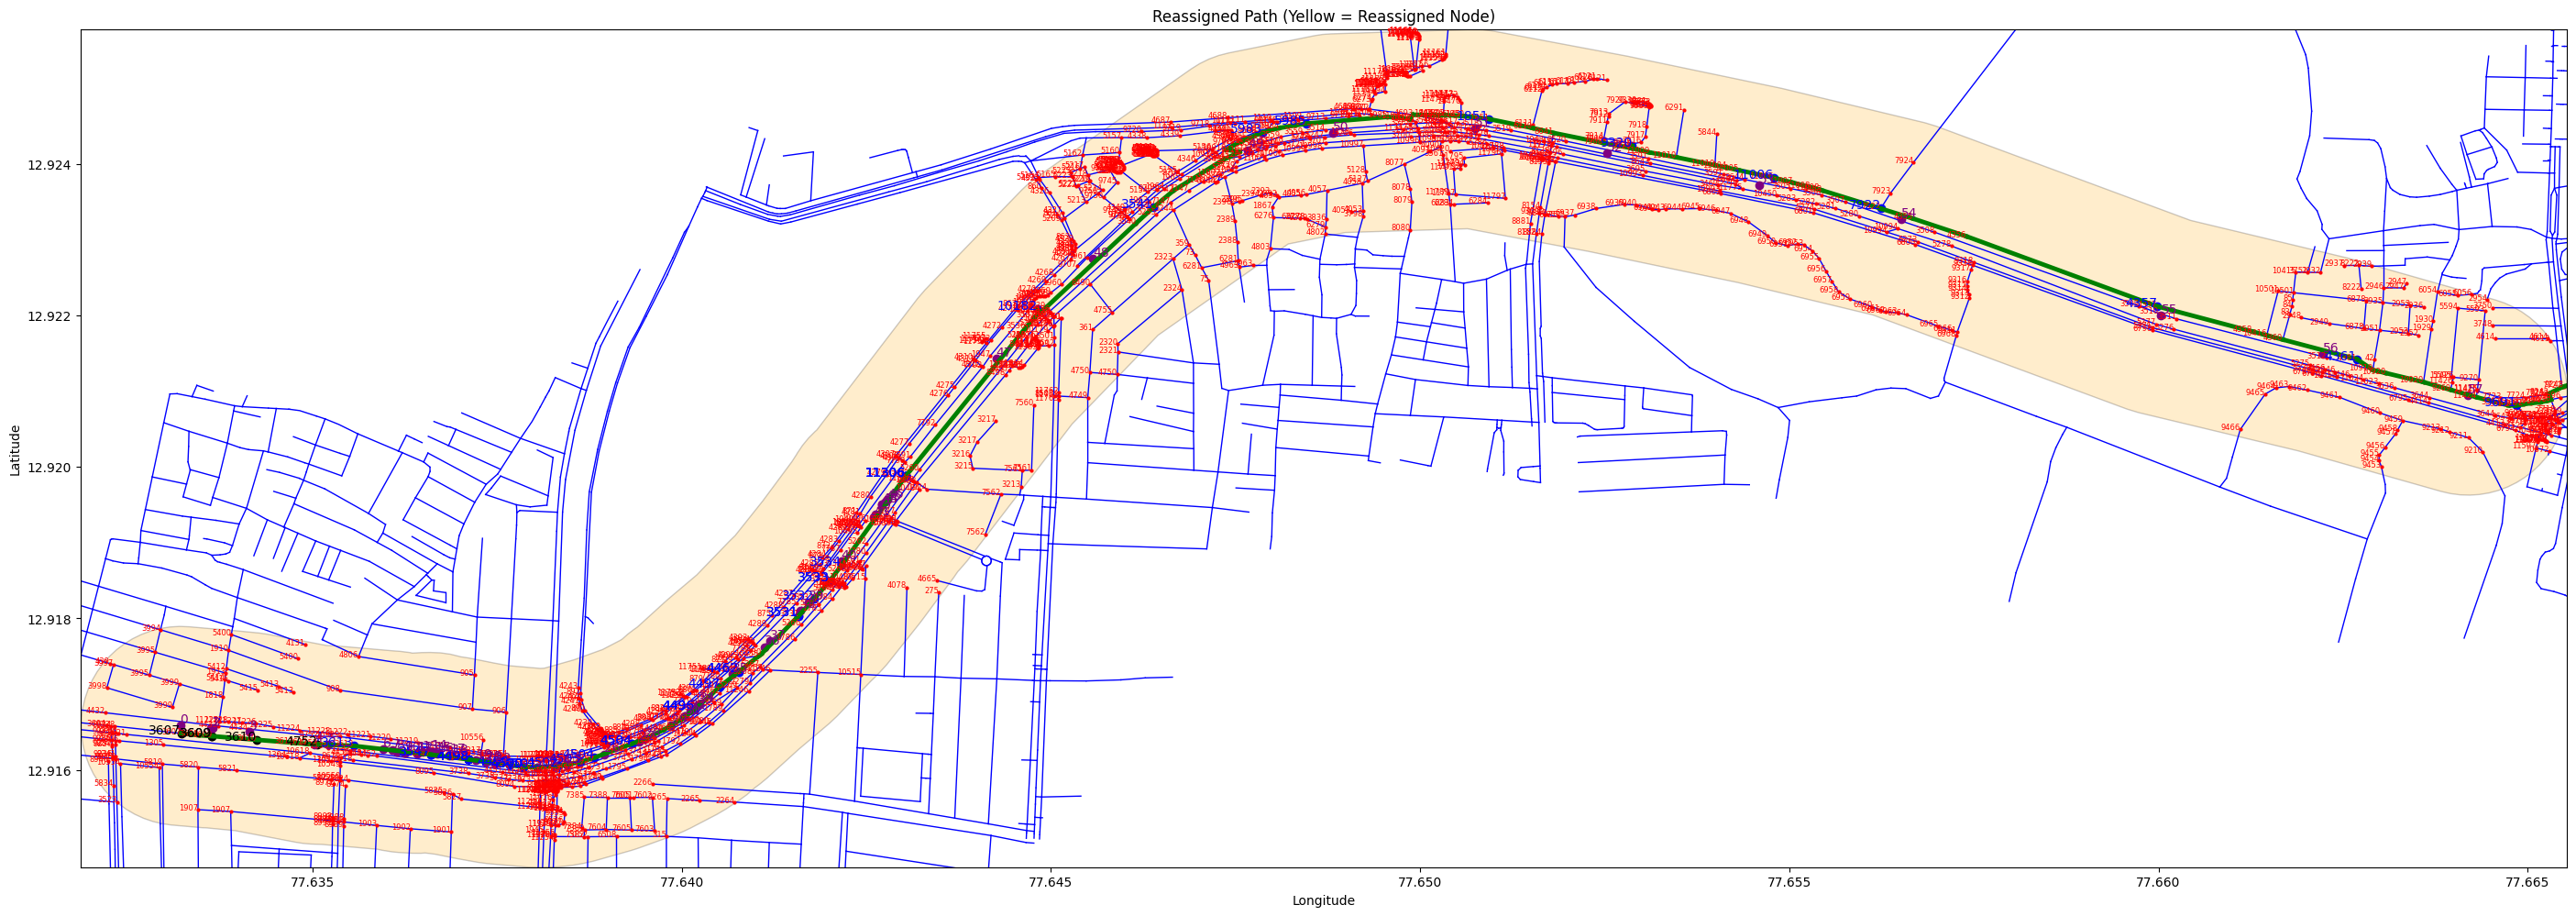

In [255]:
import networkx as nx
import matplotlib.pyplot as plt
import gpxpy
import geopandas as gpd
from shapely.geometry import LineString, Point
from geopy.distance import geodesic
import math
import numpy as np

fp = "/Users/ashwin/Desktop/IIIT/OSM version - within 500m of the path/For_Route_g1_i79_500m.shp"
gpx_file_path = '/Users/ashwin/Desktop/IIIT/fefa3de2-c689-4017-a629-baf7e68f5d69_493.gpx'

data = gpd.read_file(fp)
G = nx.Graph()
coord_to_index = {}

for idx, line in enumerate(data.geometry):
    if line.geom_type == 'LineString':
        start, end = Point(line.coords[0]), Point(line.coords[-1])
        start_coord = tuple(start.coords[0])
        end_coord = tuple(end.coords[-1])
        G.add_node(start_coord, pos=start_coord)
        G.add_node(end_coord, pos=end_coord)
        G.add_edge(start_coord, end_coord, geometry=line)
        coord_to_index[start_coord] = idx
        coord_to_index[end_coord] = idx

with open(gpx_file_path, 'r') as gpx_file:
    gpx = gpxpy.parse(gpx_file)

start_index = 149
end_index = 220

observations = [
    (point.longitude, point.latitude)
    for track in gpx.tracks
    for segment in track.segments
    for i, point in enumerate(segment.points)
    if start_index <= i < end_index
]

observations_2_no = [pt for i, pt in enumerate(observations) if i == 0 or pt != observations[i - 1]]

gpx_path = LineString(observations_2_no)
gpx_gdf = gpd.GeoDataFrame(geometry=[gpx_path], crs="EPSG:4326")
gpx_gdf_3857 = gpx_gdf.to_crs(epsg=3857)
geofence_buffered_3857 = gpx_gdf_3857.buffer(150)  
geofence = geofence_buffered_3857.to_crs(epsg=4326)  

connected_components = sorted(nx.connected_components(G), key=len, reverse=True)

if connected_components:
    subgraph = G.subgraph(connected_components[0]).copy()
    pos = nx.get_node_attributes(subgraph, 'pos')
    states_in_geofence = [node for node in pos if geofence.geometry[0].contains(Point(pos[node]))]

    def geodesic_distance(a, b):
        return geodesic(a, b).kilometers

    def shortest_path_distance(G, source, target):
        path = nx.shortest_path(G, source, target, weight=lambda u, v, d: geodesic_distance(pos[u], pos[v]))
        return path, sum(geodesic_distance(pos[path[i]], pos[path[i + 1]]) for i in range(len(path) - 1))

    def calculate_heading(p1, p2):
        lon1, lat1 = map(math.radians, p1)
        lon2, lat2 = map(math.radians, p2)
        d_lon = lon2 - lon1
        x = math.sin(d_lon) * math.cos(lat2)
        y = math.cos(lat1) * math.sin(lat2) - math.sin(lat1) * math.cos(lat2) * math.cos(d_lon)
        return (math.degrees(math.atan2(x, y)) + 360) % 360

    def angle_diff_signed(a, b):
        diff = (b - a + 360) % 360
        return diff - 360 if diff > 180 else diff

    def reassign_node(fixed_node, obs_heading, i):
        candidates = []
        obs_dist = geodesic(observations_2_no_duplicates[i - 1], observations_2_no_duplicates[i]).km
        for candidate in states_in_geofence:
            if not nx.has_path(subgraph, fixed_node, candidate):
                continue
            node_heading = calculate_heading(pos[fixed_node], pos[candidate])
            angle_difference = abs(angle_diff_signed(obs_heading, node_heading))
            _, dist_to_candidate = shortest_path_distance(subgraph, fixed_node, candidate)
            dist_difference = abs(dist_to_candidate - obs_dist)
            if angle_difference <= 5 and dist_difference <= 0.07:  
                candidates.append((angle_difference, dist_difference, candidate))
        for cand in candidates[:5]:
            print(f"Candidate idx: {coord_to_index.get(cand[2], 'N/A')}, Angle Difference: {cand[0]:.2f}°, Distance Difference: {cand[1]:.4f} km")
        if candidates:
            candidates.sort(key=lambda x: (x[0], x[1]))
            print(f"\nTop 5 candidate node numbers for observation {i}: {[coord_to_index.get(c[2], 'N/A') for c in candidates[:5]]}")
            best_candidate = candidates[0]
            return best_candidate[2], best_candidate  
        return None, None

    reassigned_nodes = [tuple(matched_coordinates_2[0])]
    reassigned_log = []
    reassignment_memory = {}

    for i in range(1, min(len(matched_coordinates_2), len(observations_2_no_duplicates))):
        fixed_node = reassigned_nodes[-1]
        target_node = tuple(matched_coordinates_2[i])
        original_index = coord_to_index.get(target_node, None)

        if original_index in reassignment_memory:
            reassigned = reassignment_memory[original_index]
            reassigned_nodes.append(reassigned)
            continue

        if fixed_node in pos and target_node in pos and nx.has_path(subgraph, fixed_node, target_node):
            _, dist = shortest_path_distance(subgraph, fixed_node, target_node)
            if dist <= 0.1:
                reassigned_nodes.append(target_node)
                continue

        obs_heading = calculate_heading(observations_2_no_duplicates[i - 1], observations_2_no_duplicates[i])
        reassigned, candidate_info = reassign_node(fixed_node, obs_heading, i)
        if reassigned:
            reassigned_nodes.append(reassigned)
            idx = coord_to_index.get(reassigned, "N/A")
            reassignment_memory[original_index] = reassigned
            print(f"Reassigned: original {original_index} → new index: {idx}, angle: {candidate_info[0]:.2f}°, dist: {candidate_info[1]*1000:.2f} m")
            reassigned_log.append((target_node, reassigned, idx, candidate_info))
        else:
            reassigned_nodes.append(fixed_node)
            idx = coord_to_index.get(fixed_node, "N/A")
            print(f"[OBS {i}] Retained (fallback): index {idx}, Node {fixed_node}, Obs {observations_2_no_duplicates[i]}")

    fig, ax = plt.subplots(figsize=(35, 17))

    for edge in subgraph.edges(data=True):
        line = edge[2]['geometry']
        x, y = line.xy
        ax.plot(x, y, color='blue', linewidth=1)

    for node in states_in_geofence:
        x, y = pos[node]
        ax.plot(x, y, marker='o', color='red', markersize=2)
        idx = coord_to_index.get((x, y), None)
        if idx is not None:
            ax.text(x, y, str(idx), fontsize=6, color='red', ha='right')

    for node in reassigned_nodes:
        if node in pos and geofence.geometry[0].contains(Point(pos[node])):
            x, y = node
            color = 'blue' if any(node == r[1] for r in reassigned_log) else 'black'
            ax.plot(x, y, marker='o', color=color, markersize=6)
            idx = coord_to_index.get((x, y), None)
            if idx is not None:
                ax.text(x, y, str(idx), fontsize=10, color=color, ha='right')

    for i, pt in enumerate(observations_2_no_duplicates):
        obs_point = Point(pt)
        if geofence.geometry[0].contains(obs_point):
            ax.plot(pt[0], pt[1], marker='o', color='purple', markersize=6)
            ax.text(pt[0], pt[1], str(i), fontsize=10, color='purple', ha='left', va='bottom')

    plotted_edges = set()
    print("--Segment Distances--")
    for i in range(1, len(reassigned_nodes)):
        a, b = reassigned_nodes[i - 1], reassigned_nodes[i]
        if a in pos and b in pos and nx.has_path(subgraph, a, b):
            path, d = shortest_path_distance(subgraph, a, b)
            print(f"Segment {i}: {d*1000:.2f} m")
            for j in range(len(path) - 1):
                edge_geom = subgraph[path[j]][path[j + 1]]['geometry']
                if (path[j], path[j + 1]) not in plotted_edges:
                    x, y = edge_geom.xy
                    ax.plot(x, y, color='green', linewidth=3.5)
                    plotted_edges.add((path[j], path[j + 1]))

    geofence.plot(ax=ax, color='orange', alpha=0.2, edgecolor='black')
    minx, miny, maxx, maxy = geofence.total_bounds
    ax.set_xlim(minx - 1e-6, maxx + 1e-6)
    ax.set_ylim(miny - 1e-6, maxy + 1e-6)
    plt.title("Reassigned Path (Yellow = Reassigned Node)")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.show()

In [256]:
# import networkx as nx
# import matplotlib.pyplot as plt
# import gpxpy
# import geopandas as gpd
# from shapely.geometry import LineString, Point
# from geopy.distance import geodesic
# import math
# import numpy as np

# fp = "/Users/ashwin/Desktop/IIIT/OSM version - within 500m of the path/For_Route_g1_i79_500m.shp"
# gpx_file_path = '/Users/ashwin/Desktop/IIIT/fefa3de2-c689-4017-a629-baf7e68f5d69_493.gpx'

# data = gpd.read_file(fp)
# G = nx.Graph()
# coord_to_index = {}

# for idx, line in enumerate(data.geometry):
#     if line.geom_type == 'LineString':
#         start, end = Point(line.coords[0]), Point(line.coords[-1])
#         start_coord = tuple(start.coords[0])
#         end_coord = tuple(end.coords[-1])
#         G.add_node(start_coord, pos=start_coord)
#         G.add_node(end_coord, pos=end_coord)
#         G.add_edge(start_coord, end_coord, geometry=line)
#         coord_to_index[start_coord] = idx
#         coord_to_index[end_coord] = idx

# with open(gpx_file_path, 'r') as gpx_file:
#     gpx = gpxpy.parse(gpx_file)

# start_index = 149
# end_index = 221

# observations = [
#     (point.longitude, point.latitude)
#     for track in gpx.tracks
#     for segment in track.segments
#     for i, point in enumerate(segment.points)
#     if start_index <= i < end_index
# ]

# observations_2_no = [pt for i, pt in enumerate(observations) if i == 0 or pt != observations[i - 1]]
# observations_2_no_duplicates = observations_2_no

# gpx_path = LineString(observations_2_no)
# gpx_gdf = gpd.GeoDataFrame(geometry=[gpx_path], crs="EPSG:4326")
# gpx_gdf_3857 = gpx_gdf.to_crs(epsg=3857)
# geofence_buffered_3857 = gpx_gdf_3857.buffer(150)  
# geofence = geofence_buffered_3857.to_crs(epsg=4326)  

# connected_components = sorted(nx.connected_components(G), key=len, reverse=True)

# if connected_components:
#     subgraph = G.subgraph(connected_components[0]).copy()
#     pos = nx.get_node_attributes(subgraph, 'pos')
#     states_in_geofence = [node for node in pos if geofence.geometry[0].contains(Point(pos[node]))]

#     def geodesic_distance(a, b):
#         return geodesic(a, b).kilometers

#     def shortest_path_distance(G, source, target):
#         path = nx.shortest_path(G, source, target, weight=lambda u, v, d: geodesic_distance(pos[u], pos[v]))
#         return path, sum(geodesic_distance(pos[path[i]], pos[path[i + 1]]) for i in range(len(path) - 1))

#     def calculate_heading(p1, p2):
#         lon1, lat1 = map(math.radians, p1)
#         lon2, lat2 = map(math.radians, p2)
#         d_lon = lon2 - lon1
#         x = math.sin(d_lon) * math.cos(lat2)
#         y = math.cos(lat1) * math.sin(lat2) - math.sin(lat1) * math.cos(lat2) * math.cos(d_lon)
#         return (math.degrees(math.atan2(x, y)) + 360) % 360

#     def angle_diff_signed(a, b):
#         diff = (b - a + 360) % 360
#         return diff - 360 if diff > 180 else diff

#     def reassign_node(fixed_node, obs_heading, i):
#         candidate_raw = []
#         obs_dist = geodesic(observations_2_no_duplicates[i - 1], observations_2_no_duplicates[i]).km
#         for candidate in states_in_geofence:
#             if not nx.has_path(subgraph, fixed_node, candidate):
#                 continue
#             node_heading = calculate_heading(pos[fixed_node], pos[candidate])
#             angle_difference = abs(angle_diff_signed(obs_heading, node_heading))
#             _, dist_to_candidate = shortest_path_distance(subgraph, fixed_node, candidate)
#             dist_difference = abs(dist_to_candidate - obs_dist)
#             candidate_raw.append((angle_difference, dist_difference, candidate))
#         if not candidate_raw:
#             return None, None
#         avg_angle = np.mean([c[0] for c in candidate_raw])
#         avg_dist = np.mean([c[1] for c in candidate_raw])
#         angle_weight = 1 / avg_angle if avg_angle != 0 else 1
#         distance_weight = 1 / avg_dist if avg_dist != 0 else 1
#         candidates = []
#         for angle_diff, dist_diff, cand in candidate_raw:
#             score = angle_diff * angle_weight + dist_diff * distance_weight
#             candidates.append((score, angle_diff, dist_diff, cand))
#         candidates.sort(key=lambda x: x[0])
#         best_candidate = candidates[0]
#         for cand in candidates[:5]:
#             print(f"Candidate idx: {coord_to_index.get(cand[3], 'N/A')}, Angle: {cand[1]:.2f}°, Dist: {cand[2]*1000:.2f} m, Score: {cand[0]:.2f}")
#         return best_candidate[3], best_candidate

#     matched_coordinates_2 = [tuple(observations_2_no_duplicates[0])] + [
#         min(states_in_geofence, key=lambda s: geodesic(observations_2_no_duplicates[i], s).km)
#         for i in range(1, len(observations_2_no_duplicates))
#     ]

#     reassigned_nodes = [tuple(matched_coordinates_2[0])]
#     reassigned_log = []
#     reassignment_memory = {}

#     for i in range(1, min(len(matched_coordinates_2), len(observations_2_no_duplicates))):
#         fixed_node = reassigned_nodes[-1]
#         target_node = tuple(matched_coordinates_2[i])
#         original_index = coord_to_index.get(target_node, None)
#         if original_index in reassignment_memory:
#             reassigned = reassignment_memory[original_index]
#             reassigned_nodes.append(reassigned)
#             continue
#         if fixed_node in pos and target_node in pos and nx.has_path(subgraph, fixed_node, target_node):
#             _, dist = shortest_path_distance(subgraph, fixed_node, target_node)
#             if dist <= 0.1:
#                 reassigned_nodes.append(target_node)
#                 continue
#         obs_heading = calculate_heading(observations_2_no_duplicates[i - 1], observations_2_no_duplicates[i])
#         reassigned, candidate_info = reassign_node(fixed_node, obs_heading, i)
#         if reassigned:
#             reassigned_nodes.append(reassigned)
#             idx = coord_to_index.get(reassigned, "N/A")
#             reassignment_memory[original_index] = reassigned
#             print(f"Reassigned: original {original_index} → new index: {idx}, angle: {candidate_info[1]:.2f}°, dist: {candidate_info[2]*1000:.2f} m")
#             reassigned_log.append((target_node, reassigned, idx, candidate_info))
#         else:
#             reassigned_nodes.append(fixed_node)
#             idx = coord_to_index.get(fixed_node, "N/A")
#             print(f"[OBS {i}] Retained (fallback): index {idx}, Node {fixed_node}, Obs {observations_2_no_duplicates[i]}")

#     fig, ax = plt.subplots(figsize=(35, 17))

#     for edge in subgraph.edges(data=True):
#         line = edge[2]['geometry']
#         x, y = line.xy
#         ax.plot(x, y, color='blue', linewidth=1)

#     for node in states_in_geofence:
#         x, y = pos[node]
#         ax.plot(x, y, marker='o', color='red', markersize=2)
#         idx = coord_to_index.get((x, y), None)
#         if idx is not None:
#             ax.text(x, y, str(idx), fontsize=6, color='red', ha='right')

#     for node in reassigned_nodes:
#         if node in pos and geofence.geometry[0].contains(Point(pos[node])):
#             x, y = node
#             color = 'blue' if any(node == r[1] for r in reassigned_log) else 'black'
#             ax.plot(x, y, marker='o', color=color, markersize=6)
#             idx = coord_to_index.get((x, y), None)
#             if idx is not None:
#                 ax.text(x, y, str(idx), fontsize=10, color=color, ha='right')

#     for i, pt in enumerate(observations_2_no_duplicates):
#         obs_point = Point(pt)
#         if geofence.geometry[0].contains(obs_point):
#             ax.plot(pt[0], pt[1], marker='o', color='purple', markersize=6)
#             ax.text(pt[0], pt[1], str(i), fontsize=10, color='purple', ha='left', va='bottom')

#     plotted_edges = set()
#     print("--Segment Distances--")
#     for i in range(1, len(reassigned_nodes)):
#         a, b = reassigned_nodes[i - 1], reassigned_nodes[i]
#         if a in pos and b in pos and nx.has_path(subgraph, a, b):
#             path, d = shortest_path_distance(subgraph, a, b)
#             print(f"Segment {i}: {d*1000:.2f} m")
#             for j in range(len(path) - 1):
#                 edge_geom = subgraph[path[j]][path[j + 1]]['geometry']
#                 if (path[j], path[j + 1]) not in plotted_edges:
#                     x, y = edge_geom.xy
#                     ax.plot(x, y, color='green', linewidth=3.5)
#                     plotted_edges.add((path[j], path[j + 1]))

#     geofence.plot(ax=ax, color='orange', alpha=0.2, edgecolor='black')
#     minx, miny, maxx, maxy = geofence.total_bounds
#     ax.set_xlim(minx - 1e-6, maxx + 1e-6)
#     ax.set_ylim(miny - 1e-6, maxy + 1e-6)
#     plt.title("Reassigned Path (Blue = Reassigned Node)")
#     plt.xlabel("Longitude")
#     plt.ylabel("Latitude")
#     plt.show()


In [257]:
index1 = 11306
index2 = 5260
index_to_coord = {v: k for k, v in coord_to_index.items()}
node1 = index_to_coord.get(index1)
node2 = index_to_coord.get(index2)

if node1 is None or node2 is None:
    print("Invalid index.")
elif nx.has_path(subgraph, node1, node2):
    print("Path exists between the nodes.")
    path = nx.shortest_path(
        subgraph,
        source=node1,
        target=node2,
        weight=lambda u, v, d: geodesic_distance(pos[u], pos[v])
    )

    total_length = 0
    for u, v in zip(path[:-1], path[1:]):
        total_length += geodesic_distance(pos[u], pos[v])

    heading_angle = calculate_heading(node1, node2)
    
    print("Shortest path length (meters):", total_length)
    print("Number of edges in path:", len(path) - 1)
    print(f"Heading angle from node {index1} to {index2}: {heading_angle:.2f}°")


Path exists between the nodes.
Shortest path length (meters): 0.020966108438270514
Number of edges in path: 2
Heading angle from node 11306 to 5260: 65.50°


In [258]:
target_obs_index = 41                          
fixed_node_index = 3534                        

fixed_node = [k for k, v in coord_to_index.items() if v == fixed_node_index][0]
candidate_node = [k for k, v in coord_to_index.items() if v == 11306][0]

obs_curr = observations_2_no_duplicates[target_obs_index]
obs_prev = observations_2_no_duplicates[target_obs_index - 1]

obs_heading = calculate_heading(obs_prev, obs_curr)
node_heading = calculate_heading(pos[fixed_node], pos[candidate_node])
angle_difference = abs(angle_diff_signed(obs_heading, node_heading))

_, dist_to_candidate = shortest_path_distance(subgraph, fixed_node, candidate_node)
obs_dist = geodesic(obs_prev, obs_curr).km
dist_difference = abs(dist_to_candidate - obs_dist)

print(">>> DEBUG for node 11306 at observation index", target_obs_index)
print(f"Fixed Node Index: {fixed_node_index}")
print(f"Obs Heading: {obs_heading:.2f}°, Node Heading: {node_heading:.2f}°, Angle Diff: {angle_difference:.2f}°")
print(f"Obs Dist: {obs_dist*1000:.2f} m, Path Dist: {dist_to_candidate*1000:.2f} m, Dist Diff: {dist_difference*1000:.2f} m")
print("Pass Angle Filter:", angle_difference <= 5)
print("Pass Distance Filter:", dist_difference <= 0.07)
print("Has Path:", nx.has_path(subgraph, fixed_node, candidate_node))


>>> DEBUG for node 11306 at observation index 41
Fixed Node Index: 3534
Obs Heading: 36.60°, Node Heading: 39.50°, Angle Diff: 2.91°
Obs Dist: 51.13 m, Path Dist: 109.73 m, Dist Diff: 58.60 m
Pass Angle Filter: True
Pass Distance Filter: True
Has Path: True


In [259]:
fixed_node_index = 11306
candidate_node_index = 11306
fixed_node = [k for k, v in coord_to_index.items() if v == fixed_node_index][0]
candidate_node = [k for k, v in coord_to_index.items() if v == candidate_node_index][0]

for target_obs_index in range(40, 47):
    obs_curr = observations_2_no_duplicates[target_obs_index]
    obs_prev = observations_2_no_duplicates[target_obs_index - 1]

    obs_heading = calculate_heading(obs_prev, obs_curr)
    node_heading = calculate_heading(pos[fixed_node], pos[candidate_node])
    angle_difference = abs(angle_diff_signed(obs_heading, node_heading))

    has_path = nx.has_path(subgraph, fixed_node, candidate_node)
    if has_path:
        _, dist_to_candidate = shortest_path_distance(subgraph, fixed_node, candidate_node)
    else:
        dist_to_candidate = float('inf')

    obs_dist = geodesic(obs_prev, obs_curr).km
    dist_difference = abs(dist_to_candidate - obs_dist)

    print(f"\n>>> DEBUG for obs {target_obs_index} → Node 11306")
    print(f"Fixed Node Index: {fixed_node_index}")
    print(f"Obs Heading: {obs_heading:.2f}°, Node Heading: {node_heading:.2f}°, Angle Diff: {angle_difference:.2f}°")
    print(f"Obs Dist: {obs_dist*1000:.2f} m, Path Dist: {dist_to_candidate*1000:.2f} m, Dist Diff: {dist_difference*1000:.2f} m")
    print("Pass Angle Filter:", angle_difference <= 5)
    print("Pass Distance Filter:", dist_difference <= 0.07)
    print("Has Path:", has_path)



>>> DEBUG for obs 40 → Node 11306
Fixed Node Index: 11306
Obs Heading: 38.56°, Node Heading: 0.00°, Angle Diff: 38.56°
Obs Dist: 50.97 m, Path Dist: 0.00 m, Dist Diff: 50.97 m
Pass Angle Filter: False
Pass Distance Filter: True
Has Path: True

>>> DEBUG for obs 41 → Node 11306
Fixed Node Index: 11306
Obs Heading: 36.60°, Node Heading: 0.00°, Angle Diff: 36.60°
Obs Dist: 51.13 m, Path Dist: 0.00 m, Dist Diff: 51.13 m
Pass Angle Filter: False
Pass Distance Filter: True
Has Path: True

>>> DEBUG for obs 42 → Node 11306
Fixed Node Index: 11306
Obs Heading: 32.11°, Node Heading: 0.00°, Angle Diff: 32.11°
Obs Dist: 3.32 m, Path Dist: 0.00 m, Dist Diff: 3.32 m
Pass Angle Filter: False
Pass Distance Filter: True
Has Path: True

>>> DEBUG for obs 43 → Node 11306
Fixed Node Index: 11306
Obs Heading: 33.03°, Node Heading: 0.00°, Angle Diff: 33.03°
Obs Dist: 9.72 m, Path Dist: 0.00 m, Dist Diff: 9.72 m
Pass Angle Filter: False
Pass Distance Filter: True
Has Path: True

>>> DEBUG for obs 44 → Node

In [260]:
from tabulate import tabulate
mapping_table = []
for i, (obs_coord, reassigned_node) in enumerate(zip(observations_2_no_duplicates, reassigned_nodes)):
    if reassigned_node in coord_to_index:
        node_index = coord_to_index[reassigned_node]
    else:
        node_index = "N/A"
    mapping_table.append([i, obs_coord, reassigned_node, node_index])

print("\nObservation to Reassigned Node Mapping Table:")
print(tabulate(mapping_table, headers=["Obs Index", "Obs Coord (lon, lat)", "Reassigned Node", "Shapefile Index"]))


Observation to Reassigned Node Mapping Table:
  Obs Index  Obs Coord (lon, lat)      Reassigned Node             Shapefile Index
-----------  ------------------------  ------------------------  -----------------
          0  (77.6332063, 12.9165871)  (77.6332191, 12.9164826)               3607
          1  (77.6336246, 12.9165517)  (77.6336386, 12.9164461)               3609
          2  (77.6336503, 12.9165523)  (77.6336386, 12.9164461)               3609
          3  (77.6341376, 12.9165062)  (77.6342411, 12.9163977)               3610
          4  (77.6350269, 12.9163405)  (77.6350673, 12.9163386)               4752
          5  (77.6352159, 12.9163332)  (77.6355548, 12.9163178)               3613
          6  (77.635962, 12.91627)     (77.6365988, 12.9162034)               3547
          7  (77.636079, 12.9162616)   (77.6365988, 12.9162034)               3547
          8  (77.6361418, 12.9162442)  (77.6365988, 12.9162034)               3547
          9  (77.6362461, 12.9162279)  (

In [261]:
from tabulate import tabulate
print("\n-- Detailed Segment Distance Comparison Table --")

table_data = []
header = [
    "Obs Index",
    "Matched Index",
    "Reassigned Index",
    "Geodesic (m)",
    "Matched Path (m)",
    "Reassigned Path (m)",
    "|Matched - Geodesic| (m)",
    "|Reassigned - Geodesic| (m)"
]

total_geodesic = 0
total_matched_path = 0
total_reassigned_path = 0

for i in range(1, len(observations_2_no_duplicates)):
    obs1 = observations_2_no_duplicates[i - 1]
    obs2 = observations_2_no_duplicates[i]
    geod = geodesic(obs1, obs2).meters 

    matched1 = tuple(matched_coordinates_2[i - 1])
    matched2 = tuple(matched_coordinates_2[i])
    matched_path_len = 0
    if matched1 in pos and matched2 in pos and nx.has_path(subgraph, matched1, matched2):
        _, matched_path_len = shortest_path_distance(subgraph, matched1, matched2)
        matched_path_len *= 1000  

    reassigned1 = tuple(reassigned_nodes[i - 1])
    reassigned2 = tuple(reassigned_nodes[i])
    reassigned_path_len = 0
    if reassigned1 in pos and reassigned2 in pos and nx.has_path(subgraph, reassigned1, reassigned2):
        _, reassigned_path_len = shortest_path_distance(subgraph, reassigned1, reassigned2)
        reassigned_path_len *= 1000  

    total_geodesic += geod
    total_matched_path += matched_path_len
    total_reassigned_path += reassigned_path_len

    matched_idx = coord_to_index.get(matched2, "N/A")
    reassigned_idx = coord_to_index.get(reassigned2, "N/A")

    table_data.append([
        i,
        matched_idx,
        reassigned_idx,
        round(geod, 4),
        round(matched_path_len, 4),
        round(reassigned_path_len, 4),
        round(abs(matched_path_len - geod), 4),
        round(abs(reassigned_path_len - geod), 4)
    ])

print(tabulate(table_data, headers=header, tablefmt="rounded_grid"))

abs_error_matched = abs(total_matched_path - total_geodesic)
abs_error_reassigned = abs(total_reassigned_path - total_geodesic)
percent_error_matched = (abs_error_matched / total_geodesic) * 100
percent_error_reassigned = (abs_error_reassigned / total_geodesic) * 100

print("\n-- Total Distances and Errors --")
print(f"Total Geodesic Distance:           {round(total_geodesic, 4)} meters")
print(f"Total Matched Path Length:         {round(total_matched_path, 4)} meters")
print(f"Total Reassigned Path Length:      {round(total_reassigned_path, 4)} meters")
print(f"|Matched - Geodesic| Error:        {round(abs_error_matched, 4)} meters ({round(percent_error_matched, 2)}%)")
print(f"|Reassigned - Geodesic| Error:     {round(abs_error_reassigned, 4)} meters ({round(percent_error_reassigned, 2)}%)")



-- Detailed Segment Distance Comparison Table --
╭─────────────┬─────────────────┬────────────────────┬────────────────┬────────────────────┬───────────────────────┬────────────────────────────┬───────────────────────────────╮
│   Obs Index │   Matched Index │   Reassigned Index │   Geodesic (m) │   Matched Path (m) │   Reassigned Path (m) │   |Matched - Geodesic| (m) │   |Reassigned - Geodesic| (m) │
├─────────────┼─────────────────┼────────────────────┼────────────────┼────────────────────┼───────────────────────┼────────────────────────────┼───────────────────────────────┤
│           1 │            3609 │               3609 │        46.7076 │            46.8425 │               46.8425 │                     0.1349 │                        0.1349 │
├─────────────┼─────────────────┼────────────────────┼────────────────┼────────────────────┼───────────────────────┼────────────────────────────┼───────────────────────────────┤
│           2 │            3609 │               3609 │      

In [ ]:
# import networkx as nx
# import matplotlib.pyplot as plt
# import gpxpy
# import geopandas as gpd
# from shapely.geometry import LineString, Point
# from geopy.distance import geodesic
# import math
# import numpy as np

# fp = "/Users/ashwin/Desktop/IIIT/OSM version - within 500m of the path/For_Route_g1_i79_500m.shp"
# gpx_file_path = '/Users/ashwin/Desktop/IIIT/fefa3de2-c689-4017-a629-baf7e68f5d69_493.gpx'

# data = gpd.read_file(fp)
# G = nx.Graph()
# coord_to_index = {}

# for idx, line in enumerate(data.geometry):
#     if line.geom_type == 'LineString':
#         start, end = Point(line.coords[0]), Point(line.coords[-1])
#         start_coord = tuple(start.coords[0])
#         end_coord = tuple(end.coords[-1])
#         G.add_node(start_coord, pos=start_coord)
#         G.add_node(end_coord, pos=end_coord)
#         G.add_edge(start_coord, end_coord, geometry=line)
#         coord_to_index[start_coord] = idx
#         coord_to_index[end_coord] = idx

# with open(gpx_file_path, 'r') as gpx_file:
#     gpx = gpxpy.parse(gpx_file)

# start_index = 149
# end_index = 220

# observations = [
#     (point.longitude, point.latitude)
#     for track in gpx.tracks
#     for segment in track.segments
#     for i, point in enumerate(segment.points)
#     if start_index <= i < end_index
# ]

# observations_2_no = [pt for i, pt in enumerate(observations) if i == 0 or pt != observations[i - 1]]

# gpx_path = LineString(observations_2_no)
# gpx_gdf = gpd.GeoDataFrame(geometry=[gpx_path], crs="EPSG:4326")
# gpx_gdf_3857 = gpx_gdf.to_crs(epsg=3857)
# geofence_buffered_3857 = gpx_gdf_3857.buffer(150)  
# geofence = geofence_buffered_3857.to_crs(epsg=4326)  

# connected_components = sorted(nx.connected_components(G), key=len, reverse=True)

# if connected_components:
#     subgraph = G.subgraph(connected_components[0]).copy()
#     pos = nx.get_node_attributes(subgraph, 'pos')
#     states_in_geofence = [node for node in pos if geofence.geometry[0].contains(Point(pos[node]))]

#     def geodesic_distance(a, b):
#         return geodesic(a, b).kilometers

#     def shortest_path_distance(G, source, target):
#         path = nx.shortest_path(G, source, target, weight=lambda u, v, d: geodesic_distance(pos[u], pos[v]))
#         return path, sum(geodesic_distance(pos[path[i]], pos[path[i + 1]]) for i in range(len(path) - 1))

#     def calculate_heading(p1, p2):
#         lat1, lon1 = map(math.radians, p1)
#         lat2, lon2 = map(math.radians, p2)
#         d_lon = lon2 - lon1
#         x = math.sin(d_lon) * math.cos(lat2)
#         y = math.cos(lat1) * math.sin(lat2) - math.sin(lat1) * math.cos(lat2) * math.cos(d_lon)
#         return (math.degrees(math.atan2(x, y)) + 360) % 360

#     def angle_diff_signed(a, b):
#         diff = (b - a + 360) % 360
#         return diff - 360 if diff > 180 else diff

#     def reassign_node(fixed_node, obs_heading, i):
#         candidates = []
#         obs_dist = geodesic(observations_2_no[i - 1], observations_2_no[i]).km
#         for candidate in states_in_geofence:
#             if not nx.has_path(subgraph, fixed_node, candidate):
#                 continue
#             node_heading = calculate_heading(pos[fixed_node], pos[candidate])
#             angle_difference = abs(angle_diff_signed(obs_heading, node_heading))
#             _, dist_to_candidate = shortest_path_distance(subgraph, fixed_node, candidate)
#             dist_difference = abs(dist_to_candidate - obs_dist)
#             if angle_difference <= 5 and dist_difference <= 0.07:
#                 is_direct_neighbor = subgraph.has_edge(fixed_node, candidate)
#                 candidates.append((angle_difference, dist_difference, not is_direct_neighbor, candidate))
#         candidates.sort(key=lambda x: (x[0], x[1], x[2]))
#         for cand in candidates[:5]:
#             print(f"Candidate idx: {coord_to_index.get(cand[3], 'N/A')}, Angle Difference: {cand[0]:.2f}°, Distance Difference: {cand[1]:.4f} km")
#         if candidates:
#             best_candidate = candidates[0]
#             return best_candidate[3], best_candidate
#         return None, None

#     reassigned_nodes = [tuple(matched_coordinates_2[0])]
#     reassigned_log = []
#     reassignment_memory = {}

#     for i in range(1, min(len(matched_coordinates_2), len(observations_2_no))):
#         fixed_node = reassigned_nodes[-1]
#         target_node = tuple(matched_coordinates_2[i])
#         original_index = coord_to_index.get(target_node, None)

#         if original_index in reassignment_memory:
#             reassigned = reassignment_memory[original_index]
#             reassigned_nodes.append(reassigned)
#             continue

#         if fixed_node in pos and target_node in pos and nx.has_path(subgraph, fixed_node, target_node):
#             _, dist = shortest_path_distance(subgraph, fixed_node, target_node)
#             if dist <= 0.1:
#                 reassigned_nodes.append(target_node)
#                 continue

#         obs_heading = calculate_heading(observations_2_no[i - 1], observations_2_no[i])
#         reassigned, candidate_info = reassign_node(fixed_node, obs_heading, i)
#         if reassigned:
#             reassigned_nodes.append(reassigned)
#             idx = coord_to_index.get(reassigned, "N/A")
#             reassignment_memory[original_index] = reassigned
#             print(f"Reassigned: original {original_index} → new index: {idx}, angle: {candidate_info[0]:.2f}°, dist: {candidate_info[1]*1000:.2f} m")
#             reassigned_log.append((target_node, reassigned, idx, candidate_info))
#         else:
#             reassigned_nodes.append(target_node)
#             idx = coord_to_index.get(target_node, "N/A")
#             print(f"[OBS {i}] Retained (fallback): index {idx}, Node {target_node}, Obs {observations_2_no[i]}")

#     fig, ax = plt.subplots(figsize=(35, 17))

#     for edge in subgraph.edges(data=True):
#         line = edge[2]['geometry']
#         x, y = line.xy
#         ax.plot(x, y, color='blue', linewidth=1)

#     for node in states_in_geofence:
#         x, y = pos[node]
#         ax.plot(x, y, marker='o', color='red', markersize=2)
#         idx = coord_to_index.get((x, y), None)
#         if idx is not None:
#             ax.text(x, y, str(idx), fontsize=6, color='red', ha='right')

#     for node in reassigned_nodes:
#         if node in pos and geofence.geometry[0].contains(Point(pos[node])):
#             x, y = node
#             color = 'blue' if any(node == r[1] for r in reassigned_log) else 'black'
#             ax.plot(x, y, marker='o', color=color, markersize=6)
#             idx = coord_to_index.get((x, y), None)
#             if idx is not None:
#                 ax.text(x, y, str(idx), fontsize=10, color=color, ha='right')

#     for i, pt in enumerate(observations_2_no):
#         obs_point = Point(pt)
#         if geofence.geometry[0].contains(obs_point):
#             ax.plot(pt[0], pt[1], marker='o', color='purple', markersize=6)
#             ax.text(pt[0], pt[1], str(i), fontsize=10, color='purple', ha='left', va='bottom')

#     plotted_edges = set()
#     for i in range(1, len(reassigned_nodes)):
#         a, b = reassigned_nodes[i - 1], reassigned_nodes[i]
#         if a in pos and b in pos and nx.has_path(subgraph, a, b):
#             path, d = shortest_path_distance(subgraph, a, b)
#             for j in range(len(path) - 1):
#                 edge_geom = subgraph[path[j]][path[j + 1]]['geometry']
#                 if (path[j], path[j + 1]) not in plotted_edges:
#                     x, y = edge_geom.xy
#                     ax.plot(x, y, color='green', linewidth=3.5)
#                     plotted_edges.add((path[j], path[j + 1]))

#     geofence.plot(ax=ax, color='orange', alpha=0.2, edgecolor='black')
#     minx, miny, maxx, maxy = geofence.total_bounds
#     ax.set_xlim(minx - 1e-6, maxx + 1e-6)
#     ax.set_ylim(miny - 1e-6, maxy + 1e-6)
#     plt.title("Reassigned Path (Yellow = Reassigned Node)")
#     plt.xlabel("Longitude")
#     plt.ylabel("Latitude")
#     plt.show()

In [ ]:
# import networkx as nx
# import matplotlib.pyplot as plt
# import gpxpy
# import geopandas as gpd
# from shapely.geometry import LineString, Point
# from geopy.distance import geodesic
# import math
# import numpy as np

# fp = "/Users/ashwin/Desktop/IIIT/OSM version - within 500m of the path/For_Route_g1_i79_500m.shp"
# gpx_file_path = '/Users/ashwin/Desktop/IIIT/fefa3de2-c689-4017-a629-baf7e68f5d69_493.gpx'

# data = gpd.read_file(fp)
# G = nx.Graph()
# coord_to_index = {}

# for idx, line in enumerate(data.geometry):
#     if line.geom_type == 'LineString':
#         start, end = Point(line.coords[0]), Point(line.coords[-1])
#         start_coord = tuple(start.coords[0])
#         end_coord = tuple(end.coords[-1])
#         G.add_node(start_coord, pos=start_coord)
#         G.add_node(end_coord, pos=end_coord)
#         G.add_edge(start_coord, end_coord, geometry=line)
#         coord_to_index[start_coord] = idx
#         coord_to_index[end_coord] = idx

# with open(gpx_file_path, 'r') as gpx_file:
#     gpx = gpxpy.parse(gpx_file)

# start_index = 149
# end_index = 220

# observations = [
#     (point.longitude, point.latitude)
#     for track in gpx.tracks
#     for segment in track.segments
#     for i, point in enumerate(segment.points)
#     if start_index <= i < end_index
# ]

# observations_2_no = [pt for i, pt in enumerate(observations) if i == 0 or pt != observations[i - 1]]

# gpx_path = LineString(observations_2_no)
# gpx_gdf = gpd.GeoDataFrame(geometry=[gpx_path], crs="EPSG:4326")
# gpx_gdf_3857 = gpx_gdf.to_crs(epsg=3857)
# geofence_buffered_3857 = gpx_gdf_3857.buffer(150)  
# geofence = geofence_buffered_3857.to_crs(epsg=4326)  

# connected_components = sorted(nx.connected_components(G), key=len, reverse=True)

# if connected_components:
#     subgraph = G.subgraph(connected_components[0]).copy()
#     pos = nx.get_node_attributes(subgraph, 'pos')
#     states_in_geofence = [node for node in pos if geofence.geometry[0].contains(Point(pos[node]))]

#     def geodesic_distance(a, b):
#         return geodesic(a, b).kilometers

#     def shortest_path_distance(G, source, target):
#         path = nx.shortest_path(G, source, target, weight=lambda u, v, d: geodesic_distance(pos[u], pos[v]))
#         return path, sum(geodesic_distance(pos[path[i]], pos[path[i + 1]]) for i in range(len(path) - 1))

#     def calculate_heading(p1, p2):
#         lat1, lon1 = map(math.radians, p1)
#         lat2, lon2 = map(math.radians, p2)
#         d_lon = lon2 - lon1
#         x = math.sin(d_lon) * math.cos(lat2)
#         y = math.cos(lat1) * math.sin(lat2) - math.sin(lat1) * math.cos(lat2) * math.cos(d_lon)
#         return (math.degrees(math.atan2(x, y)) + 360) % 360

#     def angle_diff_signed(a, b):
#         diff = (b - a + 360) % 360
#         return diff - 360 if diff > 180 else diff

#     def reassign_node(fixed_node, obs_heading, i):
#         candidates = []
#         obs_dist = geodesic(observations_2_no[i - 1], observations_2_no[i]).km
#         for candidate in states_in_geofence:
#             if not nx.has_path(subgraph, fixed_node, candidate):
#                 continue
#             node_heading = calculate_heading(pos[fixed_node], pos[candidate])
#             angle_difference = abs(angle_diff_signed(obs_heading, node_heading))
#             _, dist_to_candidate = shortest_path_distance(subgraph, fixed_node, candidate)
#             dist_difference = abs(dist_to_candidate - obs_dist)
#             if angle_difference <= 5 and dist_difference <= 0.07:
#                 is_direct_neighbor = subgraph.has_edge(fixed_node, candidate)
#                 candidates.append((angle_difference, dist_difference, not is_direct_neighbor, candidate))
#         candidates.sort(key=lambda x: (x[0], x[1], x[2]))
#         for cand in candidates[:5]:
#             print(f"Candidate idx: {coord_to_index.get(cand[3], 'N/A')}, Angle Difference: {cand[0]:.2f}°, Distance Difference: {cand[1]:.4f} km")
#         if candidates:
#             best_candidate = candidates[0]
#             return best_candidate[3], best_candidate
#         return None, None

#     reassigned_nodes = [tuple(matched_coordinates_2[0])]
#     reassigned_log = []
#     reassignment_memory = {}

#     for i in range(1, min(len(matched_coordinates_2), len(observations_2_no))):
#         fixed_node = reassigned_nodes[-1]
#         target_node = tuple(matched_coordinates_2[i])
#         original_index = coord_to_index.get(target_node, None)

#         if original_index in reassignment_memory:
#             reassigned = reassignment_memory[original_index]
#             reassigned_nodes.append(reassigned)
#             continue

#         if fixed_node in pos and target_node in pos and nx.has_path(subgraph, fixed_node, target_node):
#             _, dist = shortest_path_distance(subgraph, fixed_node, target_node)
#             if dist <= 0.1:
#                 reassigned_nodes.append(target_node)
#                 continue

#         obs_heading = calculate_heading(observations_2_no[i - 1], observations_2_no[i])
#         reassigned, candidate_info = reassign_node(fixed_node, obs_heading, i)
#         if reassigned:
#             reassigned_nodes.append(reassigned)
#             idx = coord_to_index.get(reassigned, "N/A")
#             reassignment_memory[original_index] = reassigned
#             print(f"Reassigned: original {original_index} → new index: {idx}, angle: {candidate_info[0]:.2f}°, dist: {candidate_info[1]*1000:.2f} m")
#             reassigned_log.append((target_node, reassigned, idx, candidate_info))
#         else:
#             reassigned_nodes.append(target_node)
#             idx = coord_to_index.get(target_node, "N/A")
#             print(f"[OBS {i}] Retained (fallback): index {idx}, Node {target_node}, Obs {observations_2_no[i]}")

#     fig, ax = plt.subplots(figsize=(35, 17))

#     for edge in subgraph.edges(data=True):
#         line = edge[2]['geometry']
#         x, y = line.xy
#         ax.plot(x, y, color='blue', linewidth=1)

#     for node in states_in_geofence:
#         x, y = pos[node]
#         ax.plot(x, y, marker='o', color='red', markersize=2)
#         idx = coord_to_index.get((x, y), None)
#         if idx is not None:
#             ax.text(x, y, str(idx), fontsize=6, color='red', ha='right')

#     for node in reassigned_nodes:
#         if node in pos and geofence.geometry[0].contains(Point(pos[node])):
#             x, y = node
#             color = 'blue' if any(node == r[1] for r in reassigned_log) else 'black'
#             ax.plot(x, y, marker='o', color=color, markersize=6)
#             idx = coord_to_index.get((x, y), None)
#             if idx is not None:
#                 ax.text(x, y, str(idx), fontsize=10, color=color, ha='right')

#     for i, pt in enumerate(observations_2_no):
#         obs_point = Point(pt)
#         if geofence.geometry[0].contains(obs_point):
#             ax.plot(pt[0], pt[1], marker='o', color='purple', markersize=6)
#             ax.text(pt[0], pt[1], str(i), fontsize=10, color='purple', ha='left', va='bottom')

#     plotted_edges = set()
#     for i in range(1, len(reassigned_nodes)):
#         a, b = reassigned_nodes[i - 1], reassigned_nodes[i]
#         if a in pos and b in pos and nx.has_path(subgraph, a, b):
#             path, d = shortest_path_distance(subgraph, a, b)
#             for j in range(len(path) - 1):
#                 edge_geom = subgraph[path[j]][path[j + 1]]['geometry']
#                 if (path[j], path[j + 1]) not in plotted_edges:
#                     x, y = edge_geom.xy
#                     ax.plot(x, y, color='green', linewidth=3.5)
#                     plotted_edges.add((path[j], path[j + 1]))

#     geofence.plot(ax=ax, color='orange', alpha=0.2, edgecolor='black')
#     minx, miny, maxx, maxy = geofence.total_bounds
#     ax.set_xlim(minx - 1e-6, maxx + 1e-6)
#     ax.set_ylim(miny - 1e-6, maxy + 1e-6)
#     plt.title("Reassigned Path (Yellow = Reassigned Node)")
#     plt.xlabel("Longitude")
#     plt.ylabel("Latitude")
#     plt.show()